#    Predictive Modelling Using Social Profile in Online P2P Lending Market

## Problem Statement

Online peer-to-peer (P2P) lending markets enable individual consumers to borrow from, and lend money to, one another directly. We study the borrower-,loan- and group- related determinants of performance predictability in an online P2P lending market by conceptualizing financial and social strength to predict borrower rate and whether the loan would be timely paid.


In [ ]:
# Importing Libraries
import numpy as np # linear algebra
import pandas as pd # data processing

#ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#feature engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

#train test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#ML models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score


In [ ]:
loan_df = pd.read_csv('/content/Prosper_Loan_Data.csv')

In [ ]:
loan_df.shape

(113937, 81)

In [ ]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

## Data Cleaning

In [ ]:
date_columns = ['ListingCreationDate', 'DateCreditPulled','FirstRecordedCreditLine','LoanOriginationDate']
for column in date_columns:
    loan_df[column] = pd.to_datetime(loan_df[column], errors='coerce')

<ipython-input-37-d5dabfcfeccc>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  loan_df[column] = pd.to_datetime(loan_df[column], errors='coerce')
<ipython-input-37-d5dabfcfeccc>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  loan_df[column] = pd.to_datetime(loan_df[column], errors='coerce')


In [ ]:
loan_df['IncomeRange'].value_counts()

IncomeRange
$25,000-49,999    32192
$50,000-74,999    31050
$100,000+         17337
$75,000-99,999    16916
Not displayed      7741
$1-24,999          7274
Not employed        806
$0                  621
Name: count, dtype: int64

In [ ]:
# Replace 'Not employed' with '$0'
loan_df['IncomeRange'] = loan_df['IncomeRange'].replace('Not employed', '$0')

# Replace 'Not displayed' with NaN
loan_df['IncomeRange'] = loan_df['IncomeRange'].replace('Not displayed', np.nan)

# Convert the column to categorical
loan_df['IncomeRange'] = pd.Categorical(loan_df['IncomeRange'], categories=[
    '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999',
    '$75,000-99,999', '$100,000+'
], ordered=True)
print(loan_df['IncomeRange'].value_counts())

IncomeRange
$25,000-49,999    32192
$50,000-74,999    31050
$100,000+         17337
$75,000-99,999    16916
$1-24,999          7274
$0                 1427
Name: count, dtype: int64


In [ ]:
rename_cols = {'ProsperRating (numeric)': 'ProsperRating', 'ListingCategory (numeric)': 'ListingCategory'}
loan_df.rename(columns=rename_cols, inplace=True)

# Display the DataFrame after renaming columns
loan_df.head()

ListingKey  ListingNumber ListingCreationDate CreditGrade  \
0  1021339766868145413AB3B         193129 2025-04-22 09:29:18           C   
1  10273602499503308B223C1        1209647                 NaT         NaN   
2  0EE9337825851032864889A          81716 2025-04-22 00:47:06          HR   
3  0EF5356002482715299901A         658116 2025-04-22 02:35:00         NaN   
4  0F023589499656230C5E3E2         909464                 NaT         NaN   

   Term LoanStatus        ClosedDate  BorrowerAPR  BorrowerRate  LenderYield  \
0    36  Completed  14-08-2009 00:00      0.16516        0.1580       0.1380   
1    36    Current               NaN      0.12016        0.0920       0.0820   
2    36  Completed  17-12-2009 00:00      0.28269        0.2750       0.2400   
3    36    Current               NaN      0.12528        0.0974       0.0874   
4    36    Current               NaN      0.24614        0.2085       0.1985   

   EstimatedEffectiveYield  EstimatedLoss  EstimatedReturn  ProsperRating  \
0                      NaN            NaN              NaN            NaN   
1                  0.07960         0.0249          0.05470            6.0   
2                      NaN            NaN              NaN            NaN   
3                  0.08490         0.0249          0.06000            6.0   
4                  0.18316         0.0925          0.09066            3.0   

  ProsperRating (Alpha)  ProsperScore  ListingCategory BorrowerState  \
0                   NaN           NaN                0            CO   
1                     A           7.0                2            CO   
2                   NaN           NaN                0            GA   
3                     A           9.0               16            GA   
4                     D           4.0                2            MN   

      Occupation EmploymentStatus  EmploymentStatusDuration  \
0          Other    Self-employed                       2.0   
1   Professional         Employed                      44.0   
2          Other    Not available                       NaN   
3  Skilled Labor         Employed                     113.0   
4      Executive         Employed                      44.0   

   IsBorrowerHomeowner  CurrentlyInGroup                 GroupKey  \
0                 True              True                      NaN   
1                False             False                      NaN   
2                False              True  783C3371218786870A73D20   
3                 True             False                      NaN   
4                 True             False                      NaN   

     DateCreditPulled  CreditScoreRangeLower  CreditScoreRangeUpper  \
0                 NaT                  640.0                  659.0   
1 2014-02-27 08:28:00                  680.0                  699.0   
2 2025-04-22 09:10:06                  480.0                  499.0   
3 2012-10-22 11:02:00                  800.0                  819.0   
4 2013-09-14 18:38:00                  680.0                  699.0   

  FirstRecordedCreditLine  CurrentCreditLines  OpenCreditLines  \
0              2001-11-10                 5.0              4.0   
1                     NaT                14.0             14.0   
2                     NaT                 NaN              NaN   
3                     NaT                 5.0              5.0   
4                     NaT                19.0             19.0   

   TotalCreditLinespast7years  OpenRevolvingAccounts  \
0                        12.0                      1   
1                        29.0                     13   
2                         3.0                      0   
3                        29.0                      7   
4                        49.0                      6   

   OpenRevolvingMonthlyPayment  InquiriesLast6Months  TotalInquiries  \
0                           24                   3.0             3.0   
1                          389                   3.0             5.0   
2    

In [ ]:
# identify the unwanted columns and dropped them
columns_drop = ['ListingKey','ListingCreationDate', 'LoanOriginationDate','ListingNumber','LoanNumber',
                'ProsperRating (Alpha)','EstimatedReturn','EstimatedLoss','LoanKey','MemberKey',
                'LoanNumber','DateCreditPulled','FirstRecordedCreditLine']
loan_df.drop(columns_drop,axis=1,inplace=True)
loan_df.shape

(113937, 69)

## Data Labelling

In [ ]:
loan_df["LoanStatus"].value_counts()

LoanStatus
Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: count, dtype: int64

I've categorized the values in the "loanStatus" column into two main groups:

* Not_Defaulted = ['Completed','Current','FinalPaymentInProgress']
* Defaulted = ['Cancelled','Chargedoff','Defaulted','PastDue']

In [ ]:
# First deal it with the ClosedDate
loan_df["Status"] = loan_df["ClosedDate"].apply(lambda x: 1 if pd.isnull(x) else 0)

# Second deal it with the LoanCurrnetDaysDeliquent
loan_df["Status"] = loan_df["LoanCurrentDaysDelinquent"].apply(lambda x: 1 if x > 180 else 0)

In [ ]:
# Convert the 'Status' column to the category data type
loan_df['Status'] = loan_df['Status'].map({0: 'Not_Defaulted', 1: 'Defaulted'})
loan_df['Status'] = loan_df['Status'].astype('category')

In [ ]:
loan_df.Status.value_counts()

Status
Not_Defaulted    98874
Defaulted        15063
Name: count, dtype: int64

In [ ]:
loan_df.drop(['ClosedDate', 'LoanCurrentDaysDelinquent', 'LoanStatus'], axis=1, inplace=True)

### Handling Missing Values

In [ ]:
# checking null values
for column in loan_df.columns:
    null_count = loan_df[column].isnull().sum()
    if null_count > 0:
        print(f'{column}: {null_count}')

CreditGrade: 84984
BorrowerAPR: 25
EstimatedEffectiveYield: 29084
ProsperRating: 29084
ProsperScore: 29084
BorrowerState: 5515
Occupation: 3588
EmploymentStatus: 2255
EmploymentStatusDuration: 7625
GroupKey: 100596
CreditScoreRangeLower: 591
CreditScoreRangeUpper: 591
CurrentCreditLines: 7604
OpenCreditLines: 7604
TotalCreditLinespast7years: 697
InquiriesLast6Months: 697
TotalInquiries: 1159
CurrentDelinquencies: 697
AmountDelinquent: 7622
DelinquenciesLast7Years: 990
PublicRecordsLast10Years: 697
PublicRecordsLast12Months: 7604
RevolvingCreditBalance: 7604
BankcardUtilization: 7604
AvailableBankcardCredit: 7544
TotalTrades: 7544
TradesNeverDelinquent (percentage): 7544
TradesOpenedLast6Months: 7544
DebtToIncomeRatio: 8554
IncomeRange: 7741
TotalProsperLoans: 91852
TotalProsperPaymentsBilled: 91852
OnTimeProsperPayments: 91852
ProsperPaymentsLessThanOneMonthLate: 91852
ProsperPaymentsOneMonthPlusLate: 91852
ProsperPrincipalBorrowed: 91852
ProsperPrincipalOutstanding: 91852
ScorexChange

In [ ]:
# Checking null values of all columns with null values are greater than 75
high_null_values = []
total_rows = len(loan_df)

for column in loan_df.columns:
    null_percentage = (loan_df[column].isnull().sum() / total_rows) * 100
    if null_percentage > 75:
        high_null_values.append(column)

# dropping columns with high null values
for i in high_null_values:
    loan_df = loan_df.drop(i, axis=1)

# Print the shape of the DataFrame after dropping columns
print(loan_df.shape)

(113937, 57)


In [ ]:
for col in loan_df:
    if loan_df[col].isnull().sum() != 0:
        print(col,":",loan_df[col].isnull().sum())

CreditGrade : 84984
BorrowerAPR : 25
EstimatedEffectiveYield : 29084
ProsperRating : 29084
ProsperScore : 29084
BorrowerState : 5515
Occupation : 3588
EmploymentStatus : 2255
EmploymentStatusDuration : 7625
CreditScoreRangeLower : 591
CreditScoreRangeUpper : 591
CurrentCreditLines : 7604
OpenCreditLines : 7604
TotalCreditLinespast7years : 697
InquiriesLast6Months : 697
TotalInquiries : 1159
CurrentDelinquencies : 697
AmountDelinquent : 7622
DelinquenciesLast7Years : 990
PublicRecordsLast10Years : 697
PublicRecordsLast12Months : 7604
RevolvingCreditBalance : 7604
BankcardUtilization : 7604
AvailableBankcardCredit : 7544
TotalTrades : 7544
TradesNeverDelinquent (percentage) : 7544
TradesOpenedLast6Months : 7544
DebtToIncomeRatio : 8554
IncomeRange : 7741


In [ ]:
# Impute null values in numeric columns with mean or median
numeric_cols = loan_df.select_dtypes(include=['float64', 'int64']).columns
loan_df[numeric_cols] = loan_df[numeric_cols].fillna(loan_df[numeric_cols].mean())

# Impute null values in categorical columns with mode
categorical_cols = loan_df.select_dtypes(exclude=['float64', 'int64']).columns
loan_df[categorical_cols] = loan_df[categorical_cols].fillna(loan_df[categorical_cols].mode().iloc[0])

In [ ]:
# Check if there are any null values after handling
if loan_df.isnull().values.any():
    print("There are still null values after handling.")
    # Display the count of null values after handling
    for column in loan_df.columns[loan_df.isnull().any()]:
        print(column, ':', loan_df[column].isnull().sum())
else:
    print("No null values are present after handling.")

No null values are present after handling.


In [ ]:
# Checking Data Types
column_types = loan_df.dtypes
numerical_columns = column_types[column_types != object]
categorical_columns = column_types[column_types == object]
dated_columns = column_types[column_types == 'datetime64[ns]']

print("Numerical Columns:")
print(numerical_columns)

print("\nCategorical Columns:")
print(categorical_columns)

print("\nDated Columns:")
print(dated_columns)

Numerical Columns:
Term                                     int64
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
EstimatedEffectiveYield                float64
ProsperRating                          float64
ProsperScore                           float64
ListingCategory                          int64
EmploymentStatusDuration               float64
IsBorrowerHomeowner                       bool
CurrentlyInGroup                          bool
CreditScoreRangeLower                  float64
CreditScoreRangeUpper                  float64
CurrentCreditLines                     float64
OpenCreditLines                        float64
TotalCreditLinespast7years             float64
OpenRevolvingAccounts                    int64
OpenRevolvingMonthlyPayment              int64
InquiriesLast6Months                   float64
TotalInquiries                         float64
CurrentDelinquencies                   fl

In [ ]:
loan_df.duplicated().sum()

np.int64(0)

## Exploratory Data Analysis

### Univariate Analysis
Univariate analysis in machine learning involves examining the relationship between a single input variable (feature) and the target variable (output) in a dataset. It focuses on understanding the characteristics and patterns of individual features without considering the interactions between multiple variables.

First we go through the numerical columns to get the distributions:

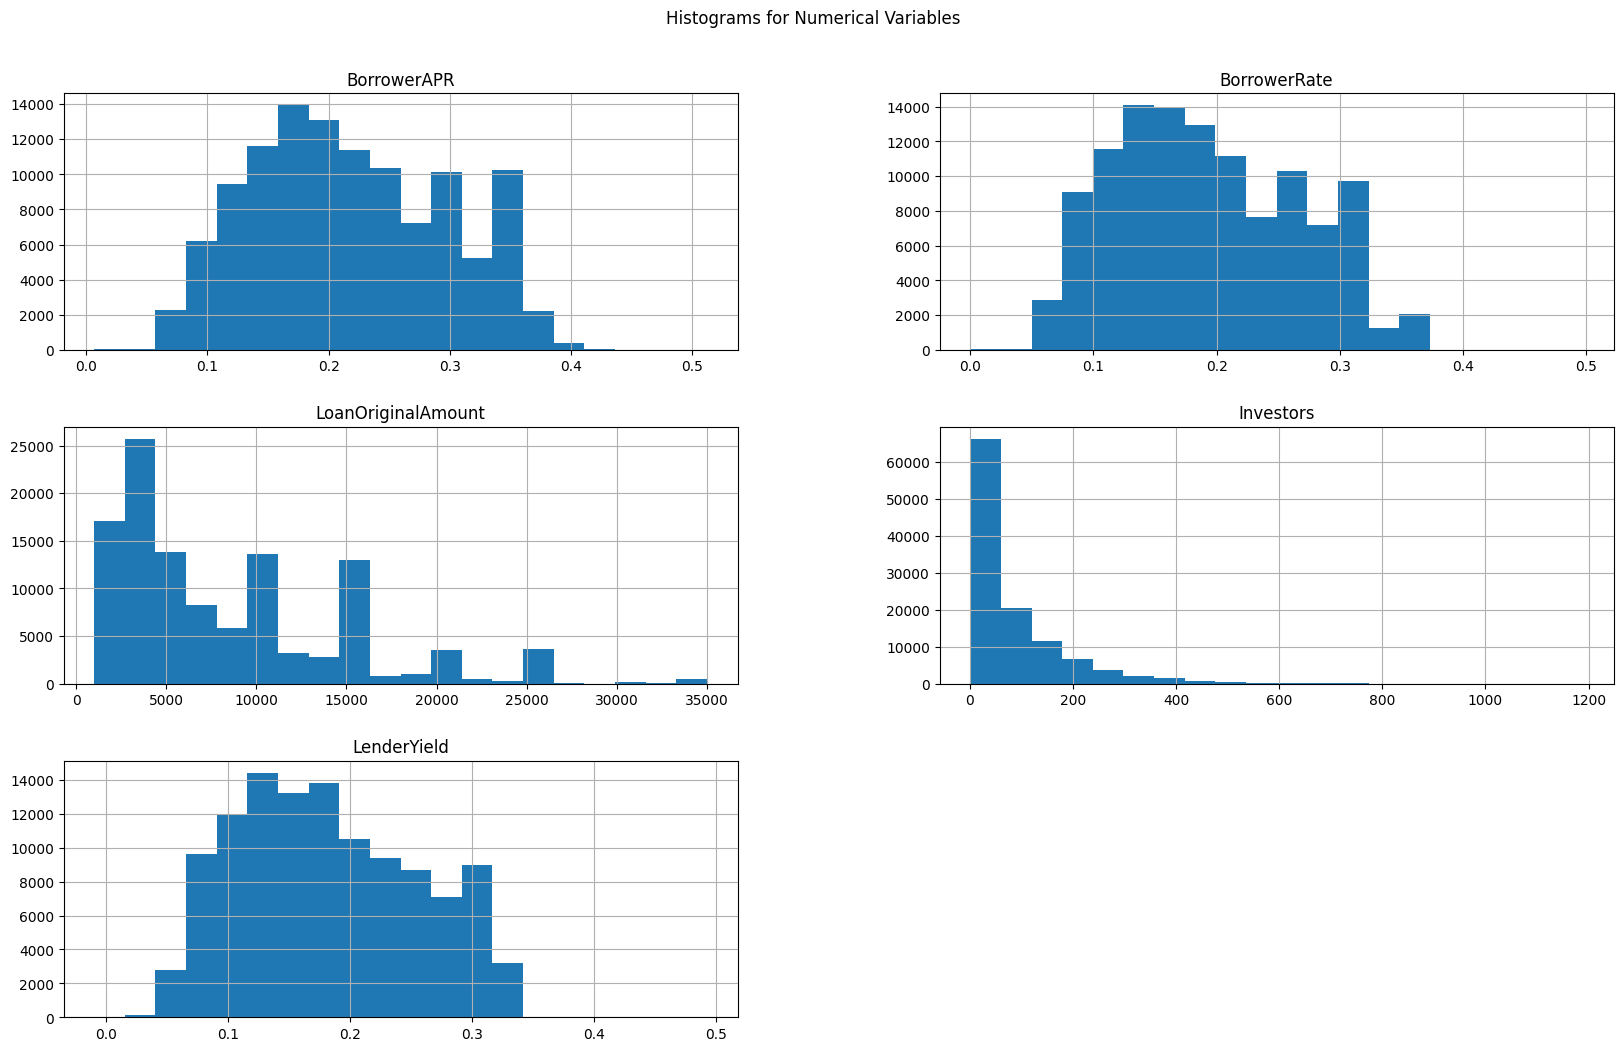

In [ ]:
num_cols = ['BorrowerAPR','BorrowerRate','LoanOriginalAmount','Investors','LenderYield']

# Subset the DataFrame with numerical columns
numerical_df = loan_df[num_cols]

# Plot histograms for numerical variables
numerical_df.hist(bins=20, figsize=(20,12))
plt.suptitle('Histograms for Numerical Variables', y=0.95)
plt.show()

### Findings of numerical columns:
* **BorrowerAPR** = We see that the Borrower APR is normally distrubuted with the peak between 15 and 20 percent in addition we have some increase in the 35 percent.
<br>

* **BorrowerRate** = From the univariate analysis of the BorrowerRate feature, we can conclude that the borrower rate is highest at 0.4975 but the majority of the borrower rate values lie in the 0.13-0.35 range, (with the most number of values being approx 0.15).
<br>

* **LoanOriginalAmount** = We see that the distribution is right skewed and also the highest value for original loan amount is between 3k and 5K.
<br>

* **Investors** = The number of investors (when more than 1) follows an approximately normal distribution centered around 100, consistent with previous expectations.
<br>

* **Lender Yield** = These feature is normally distrubuted with the peak between .15 and .18.


Frequency Table for Status:
Status
Not_Defaulted    98874
Defaulted        15063
Name: count, dtype: int64


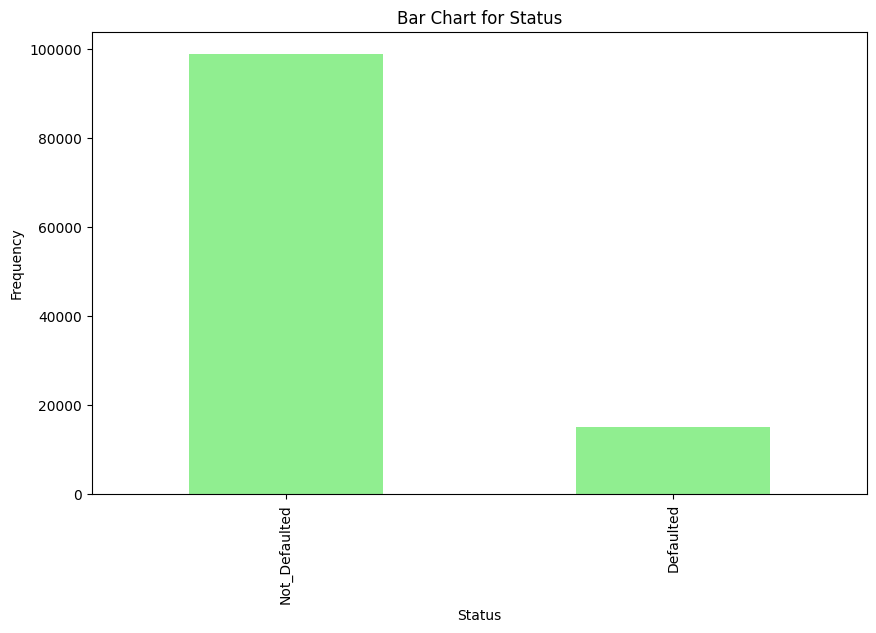


Frequency Table for EmploymentStatus:
EmploymentStatus
Employed         69577
Full-time        26355
Self-employed     6134
Not available     5347
Other             3806
Part-time         1088
Not employed       835
Retired            795
Name: count, dtype: int64


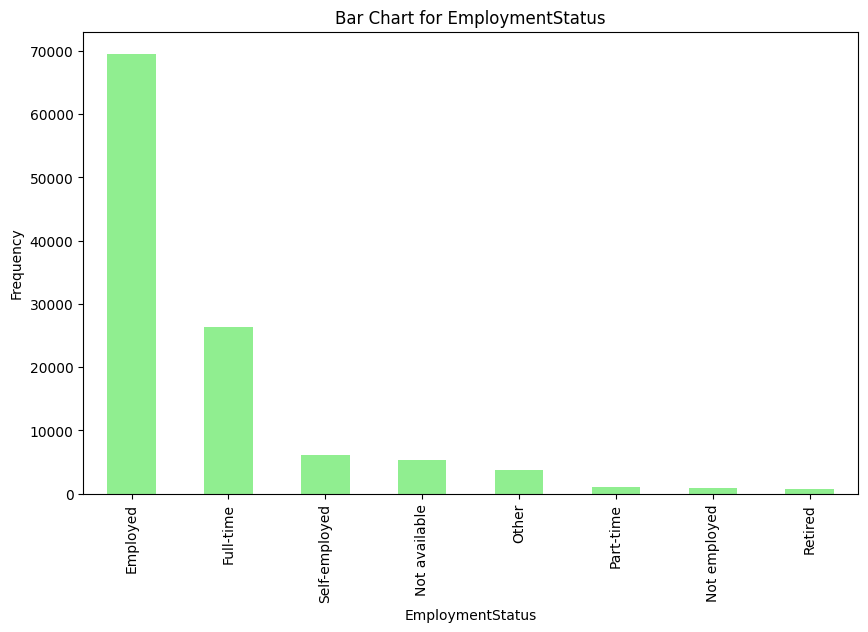


Frequency Table for IncomeRange:
IncomeRange
$25,000-49,999    39933
$50,000-74,999    31050
$100,000+         17337
$75,000-99,999    16916
$1-24,999          7274
$0                 1427
Name: count, dtype: int64


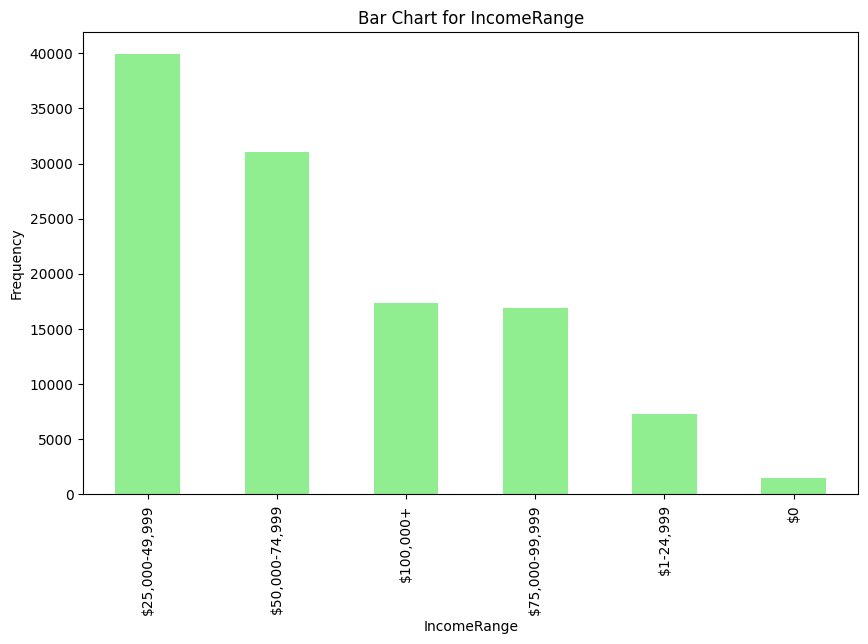


Frequency Table for CreditGrade:
CreditGrade
C     90633
D      5153
B      4389
AA     3509
HR     3508
A      3315
E      3289
NC      141
Name: count, dtype: int64


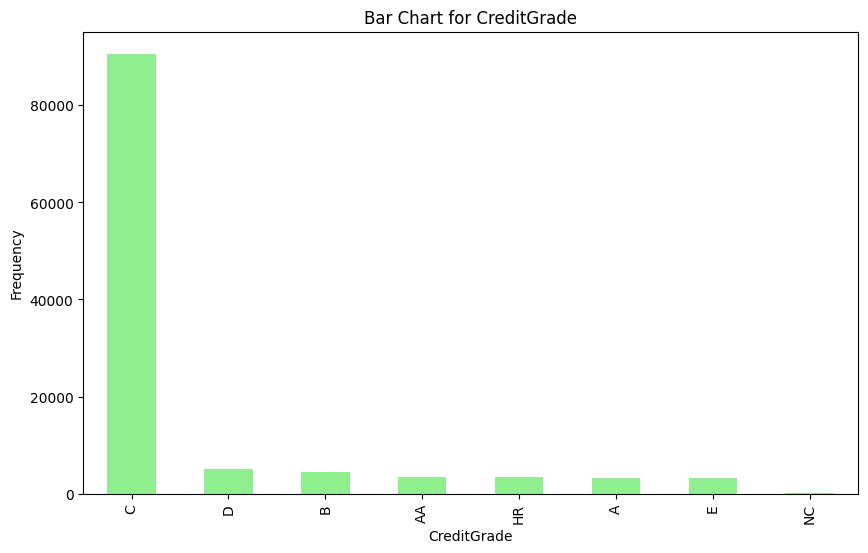


Frequency Table for BorrowerState:
BorrowerState
CA    20232
TX     6842
NY     6729
FL     6720
IL     5921
GA     5008
OH     4197
MI     3593
VA     3278
NJ     3097
NC     3084
WA     3048
PA     2972
MD     2821
MO     2615
MN     2318
MA     2242
CO     2210
IN     2078
AZ     1901
WI     1842
OR     1817
TN     1737
AL     1679
CT     1627
SC     1122
NV     1090
KS     1062
KY      983
OK      971
LA      954
UT      877
AR      855
MS      787
NE      674
ID      599
NH      551
NM      472
RI      435
HI      409
WV      391
DC      382
MT      330
DE      300
VT      207
AK      200
SD      189
IA      186
WY      150
ME      101
ND       52
Name: count, dtype: int64


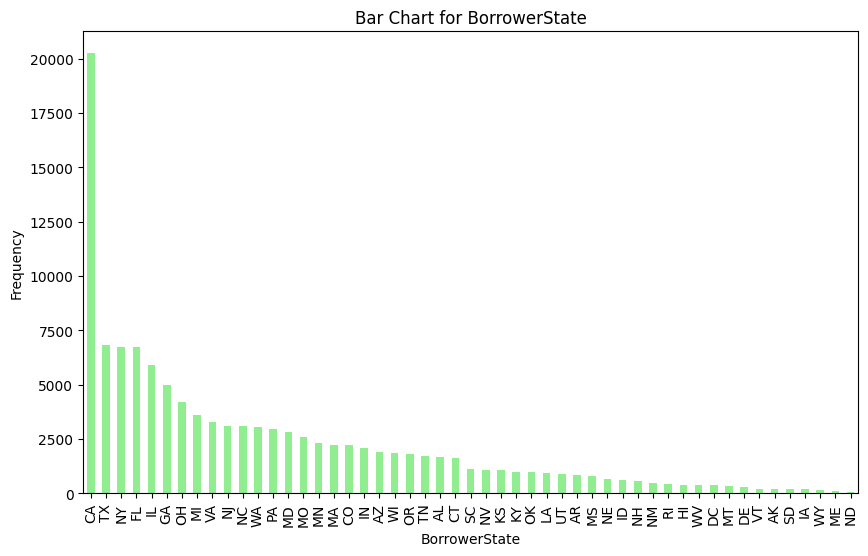

In [ ]:
categorical_columns = ['Status','EmploymentStatus', 'IncomeRange','CreditGrade', 'BorrowerState']
# Create frequency tables
for column in categorical_columns:
    freq_table = loan_df[column].value_counts()
    print(f"\nFrequency Table for {column}:\n{freq_table}")

    # Create bar chart
    plt.figure(figsize=(10, 6))
    freq_table.plot(kind='bar', color='lightgreen')
    plt.title(f'Bar Chart for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

### Findings of catgorical columns:

* **Status** = In the target variable Status , we divide into defaulted or notdefaulted categories.The class distribution is imbalanced, with a significantly higher number of instances in the "notdefaulted" class compared to the "defaulted" class. The imbalanced distribution may affect the performance of machine learning models, particularly if not addressed appropriately.
<br>

* **Employment Status** = The majority of the Employed individuals received the most loans. Higher numbers suggest that a larger proportion of employed and full-time individuals have approved loans.
<br>

* **Income Range** = The income rate distribution analysis reveals a concentration of frequency with an average income rate below 50,000 doller, followed by a decreasing count as the income range increases. The trend suggests that higher income rates correspond to fewer frequency, indicating a inverse relationship between income and frequency count.
<br>

* **Credit Grade** = C is the most common credit grade, with 90,633 occurrences.The least common credit grade is NC, with only 141 occurrences.The distribution of credit grades seems to vary, with some grades being more prevalent than others.
<br>

* **Borrower State** = California (CA) has the highest number of borrowers, with 20,232 loans.There is considerable variation in the number of loans across states, indicating potential regional economic disparities or differences in loan demand.States with higher loan counts may have a higher level of economic activity but could also pose higher risks, depending on economic conditions and other factors.

### Bivariate Analysis

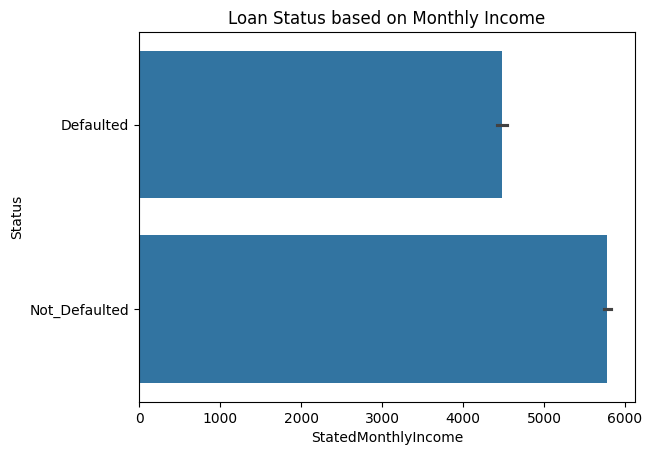

In [ ]:
# Loan Status based on Monthly Income
sns.barplot(x='StatedMonthlyIncome', y='Status', data=loan_df)

# Adding a title to your plot
plt.title("Loan Status based on Monthly Income")
plt.show()

* Here high monthly income is associated with a "not defaulted" status on loans, it suggests that individuals with higher monthly incomes are more likely to successfully repay their loans and maintain a positive loan status.

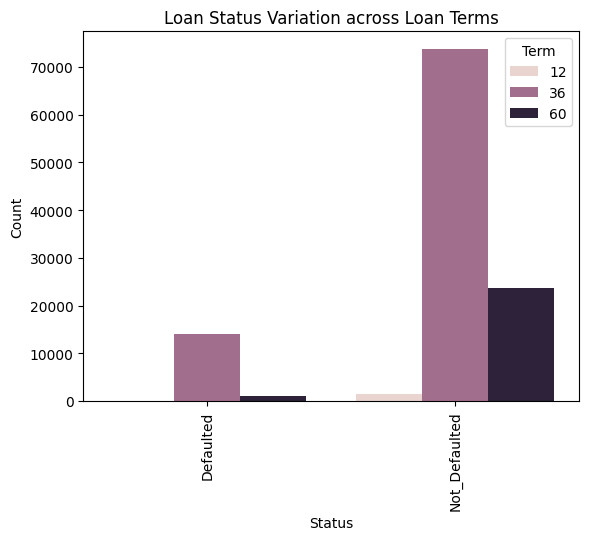

In [ ]:
# Variations in 'LoanStatus' with 'Term'
sns.countplot(data=loan_df, x='Status', hue='Term')
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Loan Status Variation across Loan Terms')
plt.xticks(rotation=90)

plt.show()

* Here, most loans with a term of 36 months are under the "not defaulted" loan status, this suggests that a higher proportion of loans with a 36-month term are in good standing and have not experienced default.

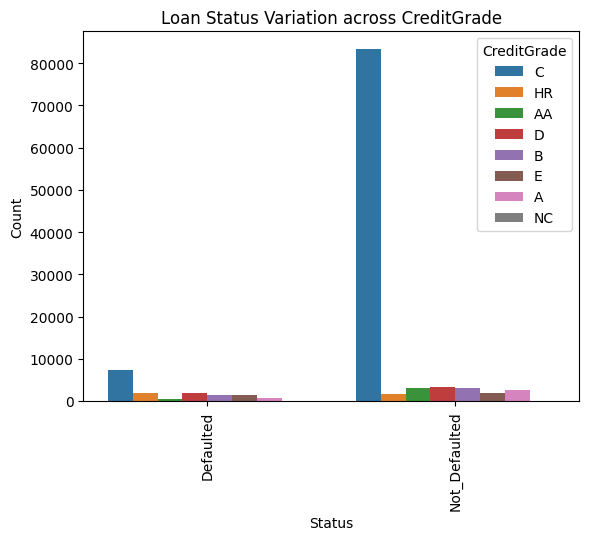

In [ ]:
sns.countplot(data=loan_df, x='Status', hue='CreditGrade')
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Loan Status Variation across CreditGrade')
plt.xticks(rotation=90)

plt.show()

* It appears that for the credit grade 'C', the majority of loans have a status of "not defaulted." This suggests that, within the 'C' credit grade, there is a higher proportion of loans that have not defaulted compared to other loan statuses.

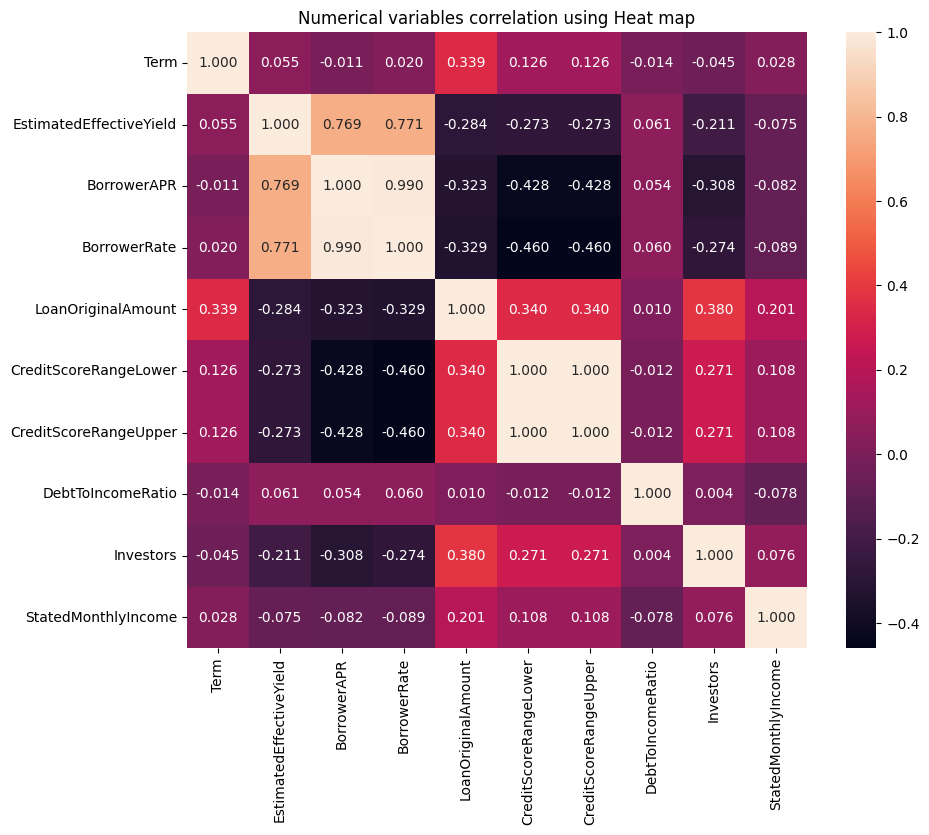

In [ ]:
# Let's make a list of all numerical variables
numeric_var = ['Term','EstimatedEffectiveYield','BorrowerAPR','BorrowerRate','LoanOriginalAmount','CreditScoreRangeLower',
               'CreditScoreRangeUpper','DebtToIncomeRatio','Investors','StatedMonthlyIncome']

# Plotting a heat map to show the correlation of each numerical variable.
plt.figure(figsize=(10,8))
sns.heatmap(data=loan_df[numeric_var].corr(),annot=True,fmt='.3f')
plt.title('Numerical variables correlation using Heat map');

* The borrower APR and borrower rate have a strong positive correlation. That the Borrower APR increases, the Borrower Rate also increses
<br>

* In variables LoanOriginalAmount,Investors,CreditScoreRangeUpper are moderate negative correlation with the borrower rate.This suggests that as the variables decreases, the borrower rate tends to increase.
<br>
* StatedMonthlyIncome is a very weak negative correlation with the borrower rate. This suggests a minimal negative relationship between the variable and target variable.

### Multivariate Analysis

<Axes: xlabel='BorrowerRate', ylabel='BorrowerAPR'>

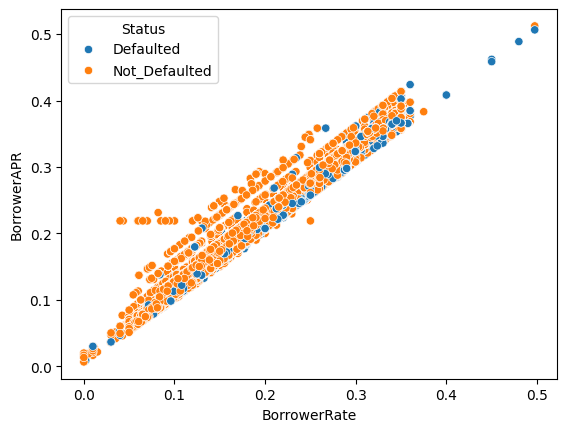

In [ ]:
# Relationship Between Borrower Rate and BorrowerAPR and Status
sns.scatterplot(data=loan_df,x='BorrowerRate',y='BorrowerAPR', hue='Status')

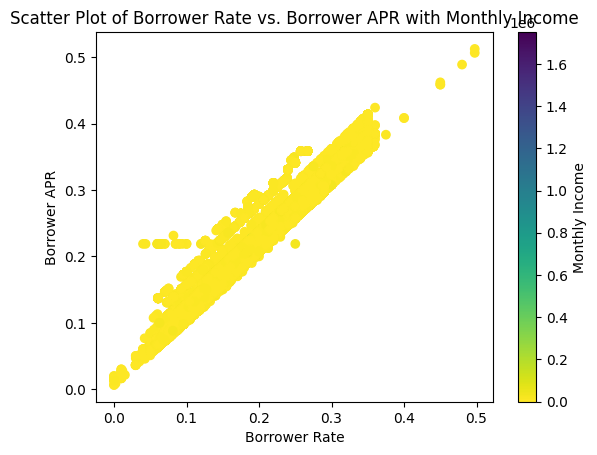

In [ ]:
plt.scatter(data=loan_df, x='BorrowerRate', y='BorrowerAPR', c='StatedMonthlyIncome', cmap='viridis_r')
plt.colorbar(label='Monthly Income')
plt.xlabel('Borrower Rate')
plt.ylabel('Borrower APR')
plt.title('Scatter Plot of Borrower Rate vs. Borrower APR with Monthly Income')
plt.show()

* Here the graph shows a positive correlation between Borrower Rate and Borrower APR, indicating that as Borrower Rate increases, Borrower APR also tends to increase. If there are any variations in the relationship between Borrower Rate and Borrower APR within this low Stated Monthly Income range.

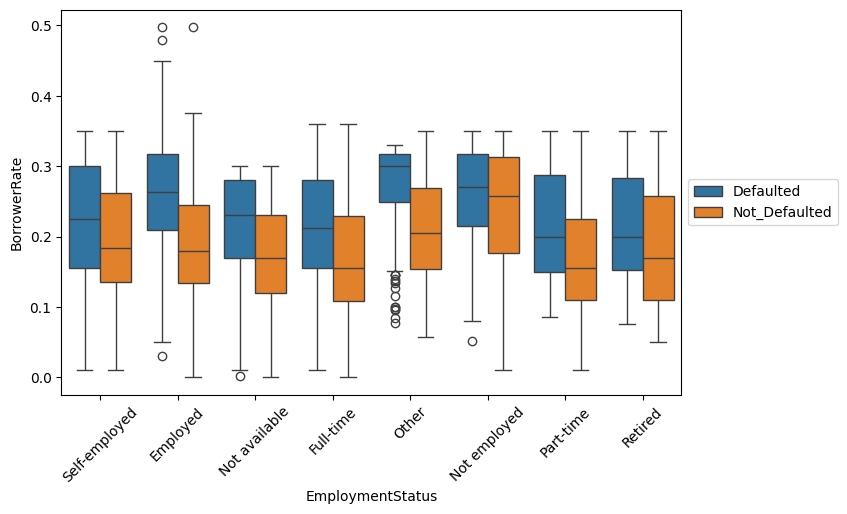

In [ ]:
plt.figure(figsize=[8, 5])
sns.boxplot(data=loan_df,x='EmploymentStatus',y='BorrowerRate',hue='Status',dodge=0.3);
plt.xticks(rotation=45);
plt.legend(loc = 6, bbox_to_anchor = (1.0, 0.5)) ;

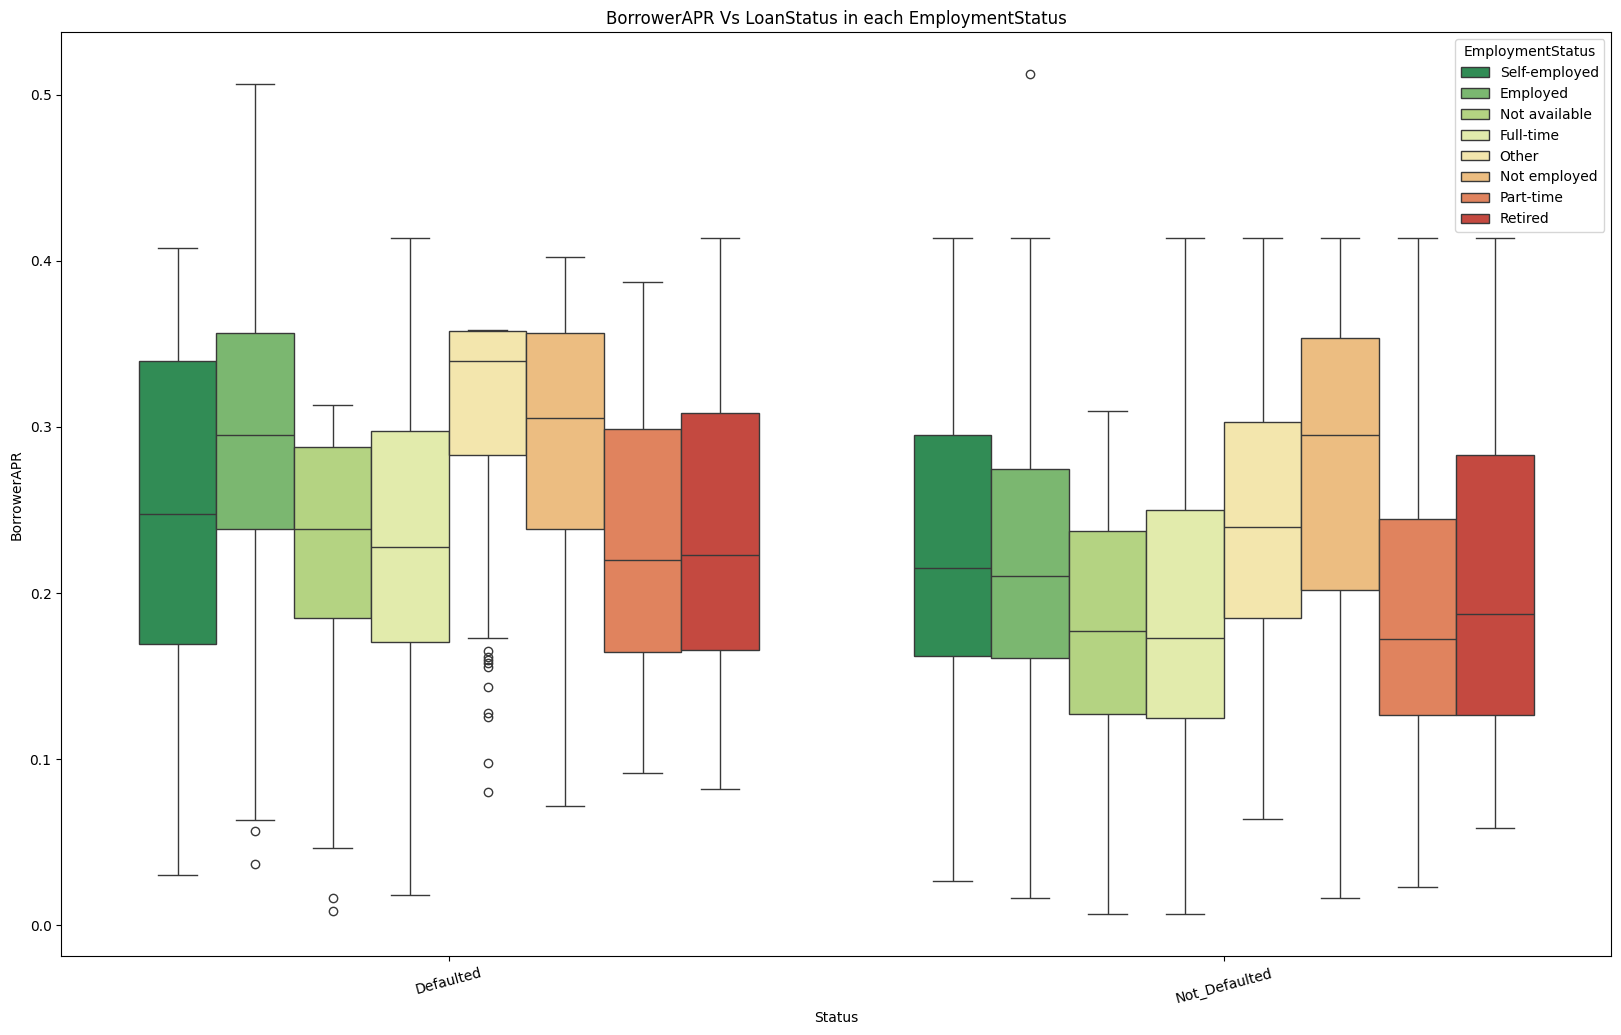

In [ ]:
# LoanStatus Vs BorrowerAPR in each EmploymentStatus
plt.figure(figsize=[20, 12])
sns.boxplot(x="Status", y="BorrowerAPR", hue="EmploymentStatus", data=loan_df, palette="RdYlGn_r")
plt.title('BorrowerAPR Vs LoanStatus in each EmploymentStatus')
plt.xlabel('Status')
plt.ylabel('BorrowerAPR')
plt.xticks(rotation=15)
plt.show()

* For each category of loan status, the lowest APR is for Employed and Full-time. Whereas highest APR is for Not employed. Most of the high BorrowerAPR are on the chargeoff, completed and current.

### Handling Outliers

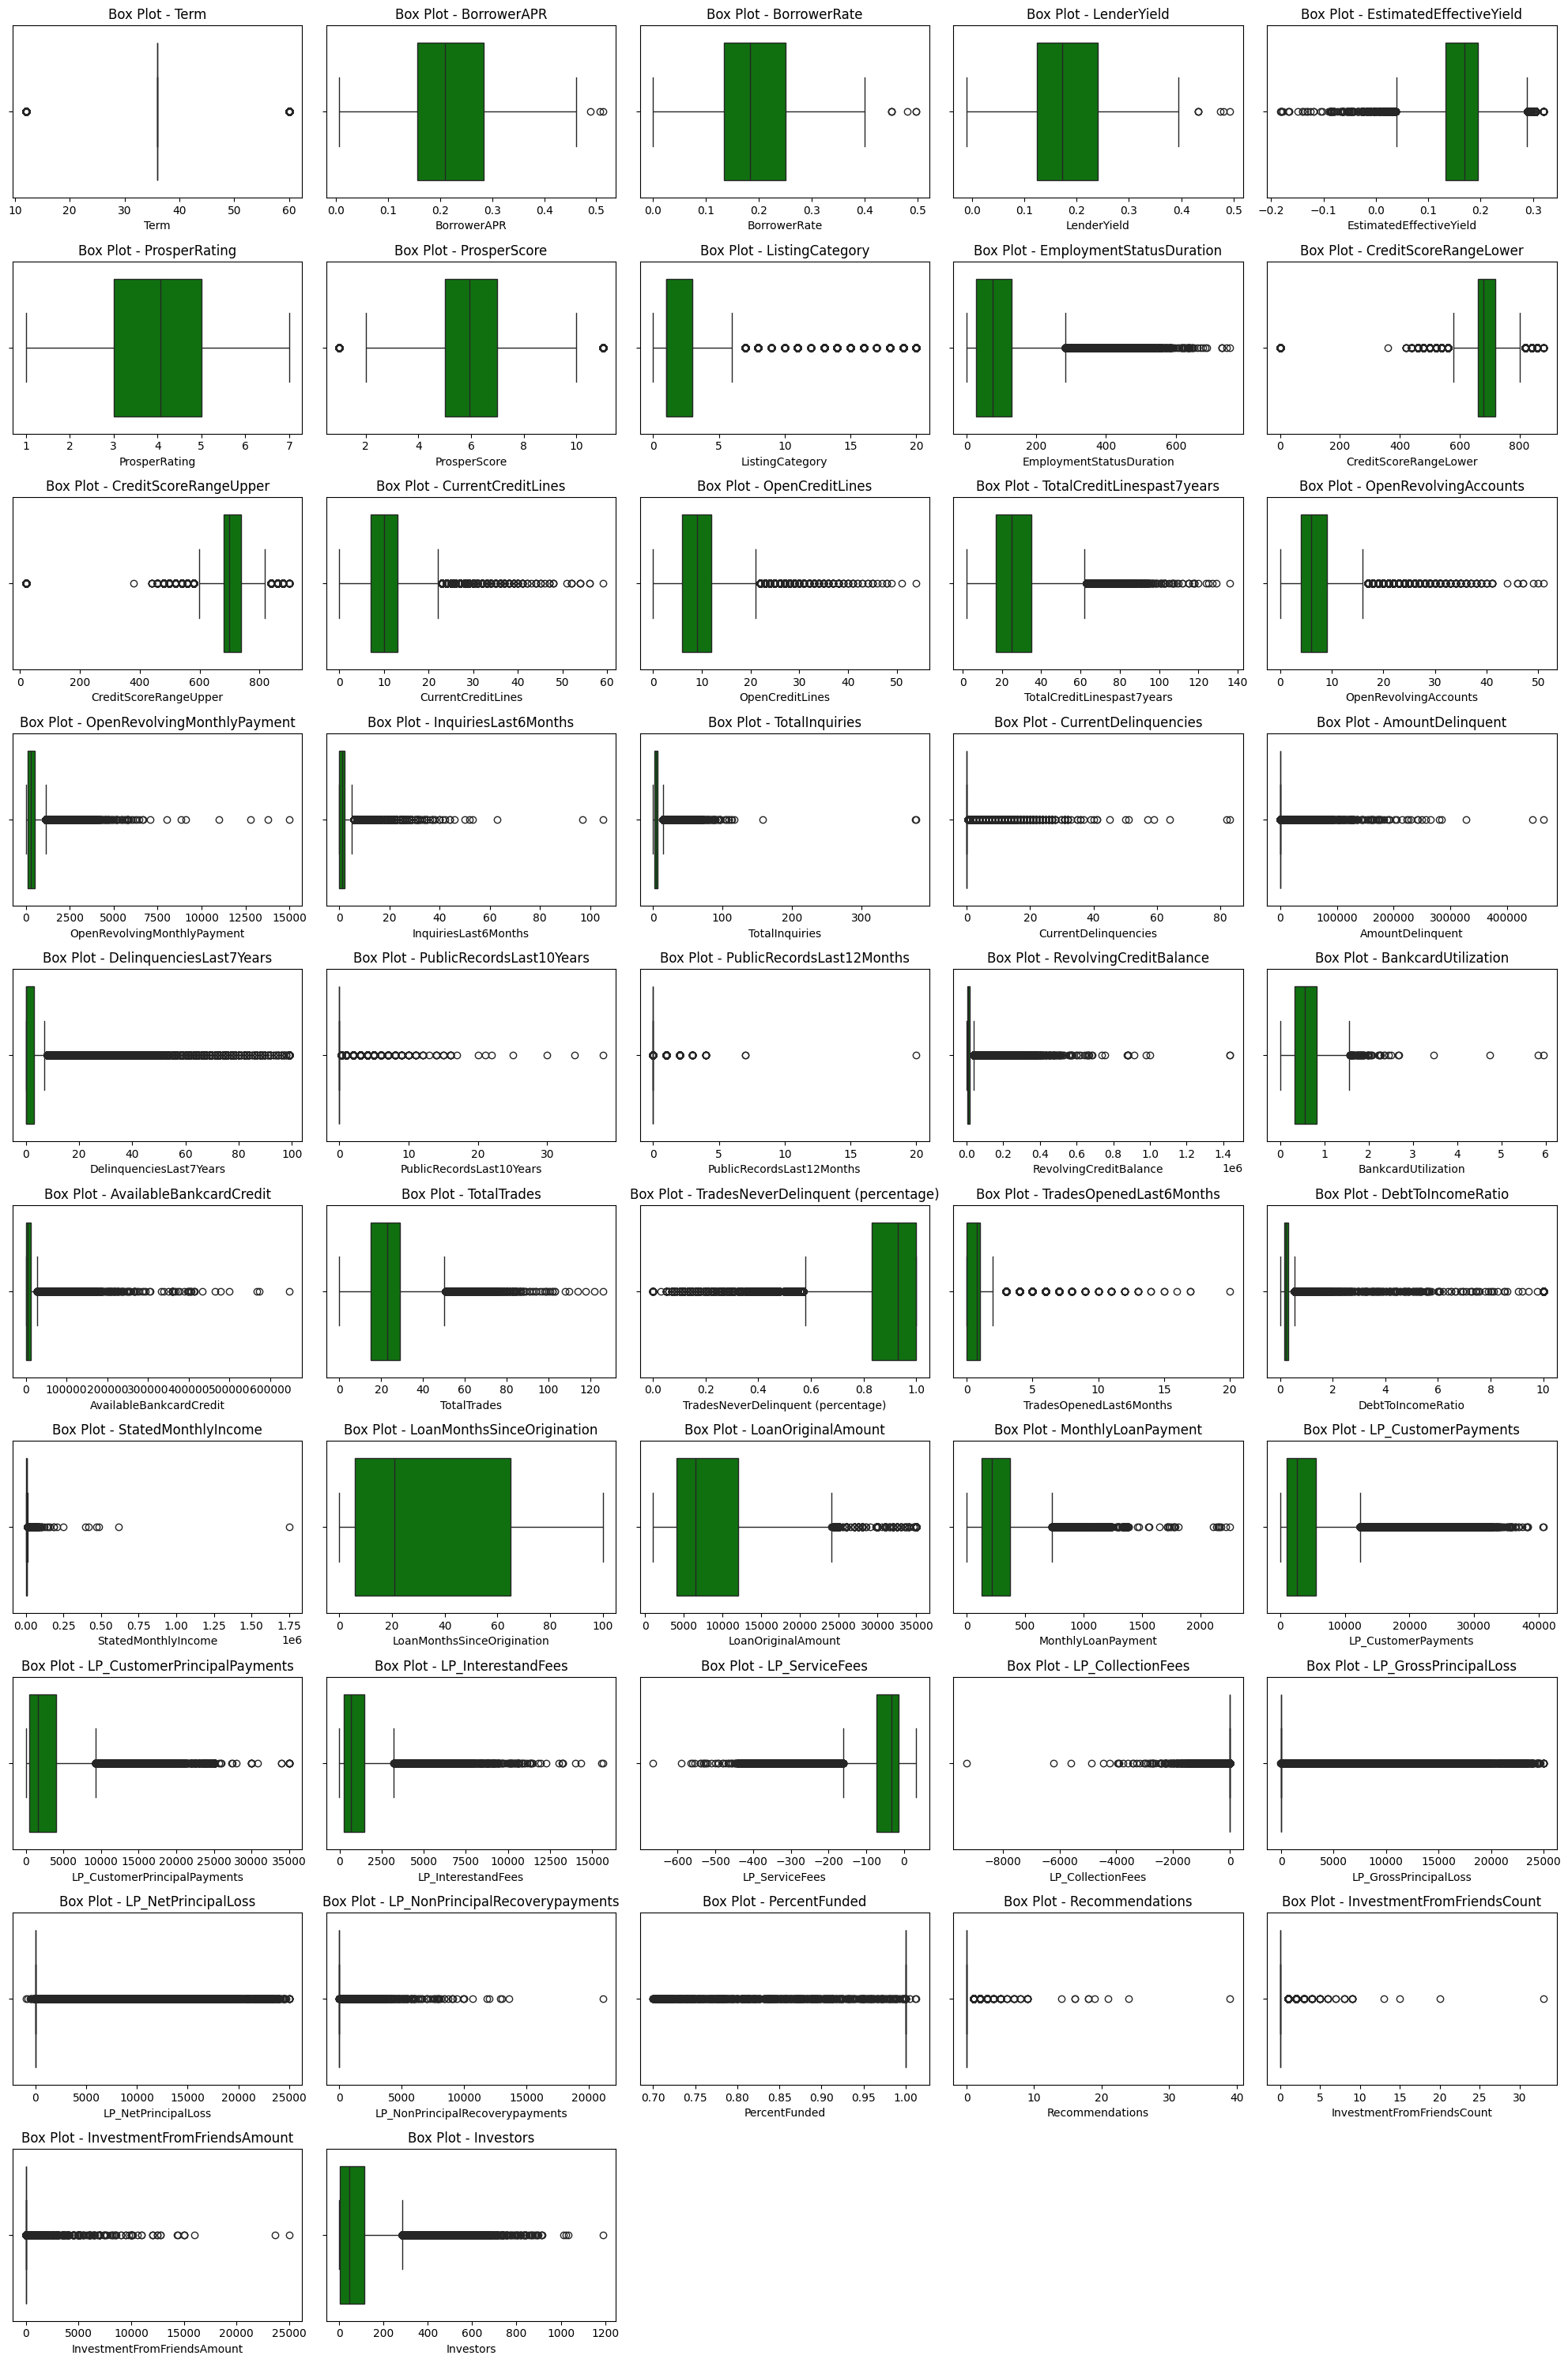

In [ ]:
# Get the list of numerical columns
num_cols = num_cols = loan_df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(20, 30))

# Create subplots
for i, column in enumerate(num_cols, 1):
    plt.subplot(10, 5, i)
    sns.boxplot(x=loan_df[column], color='green')
    plt.title(f'Box Plot - {column}')

# Adjust layout
plt.tight_layout()
plt.show()

<ipython-input-65-066b2da49268>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '40.83024829511046' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  loan_df.loc[loan_df[feature] < lower_extrem, feature] = mean
<ipython-input-65-066b2da49268>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.7742085538499346' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  loan_df.loc[loan_df[feature] < lower_extrem, feature] = mean
<ipython-input-65-066b2da49268>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.969790322722206' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  loan_df.loc[loan_df[feature] < lower_extrem, feature] = me

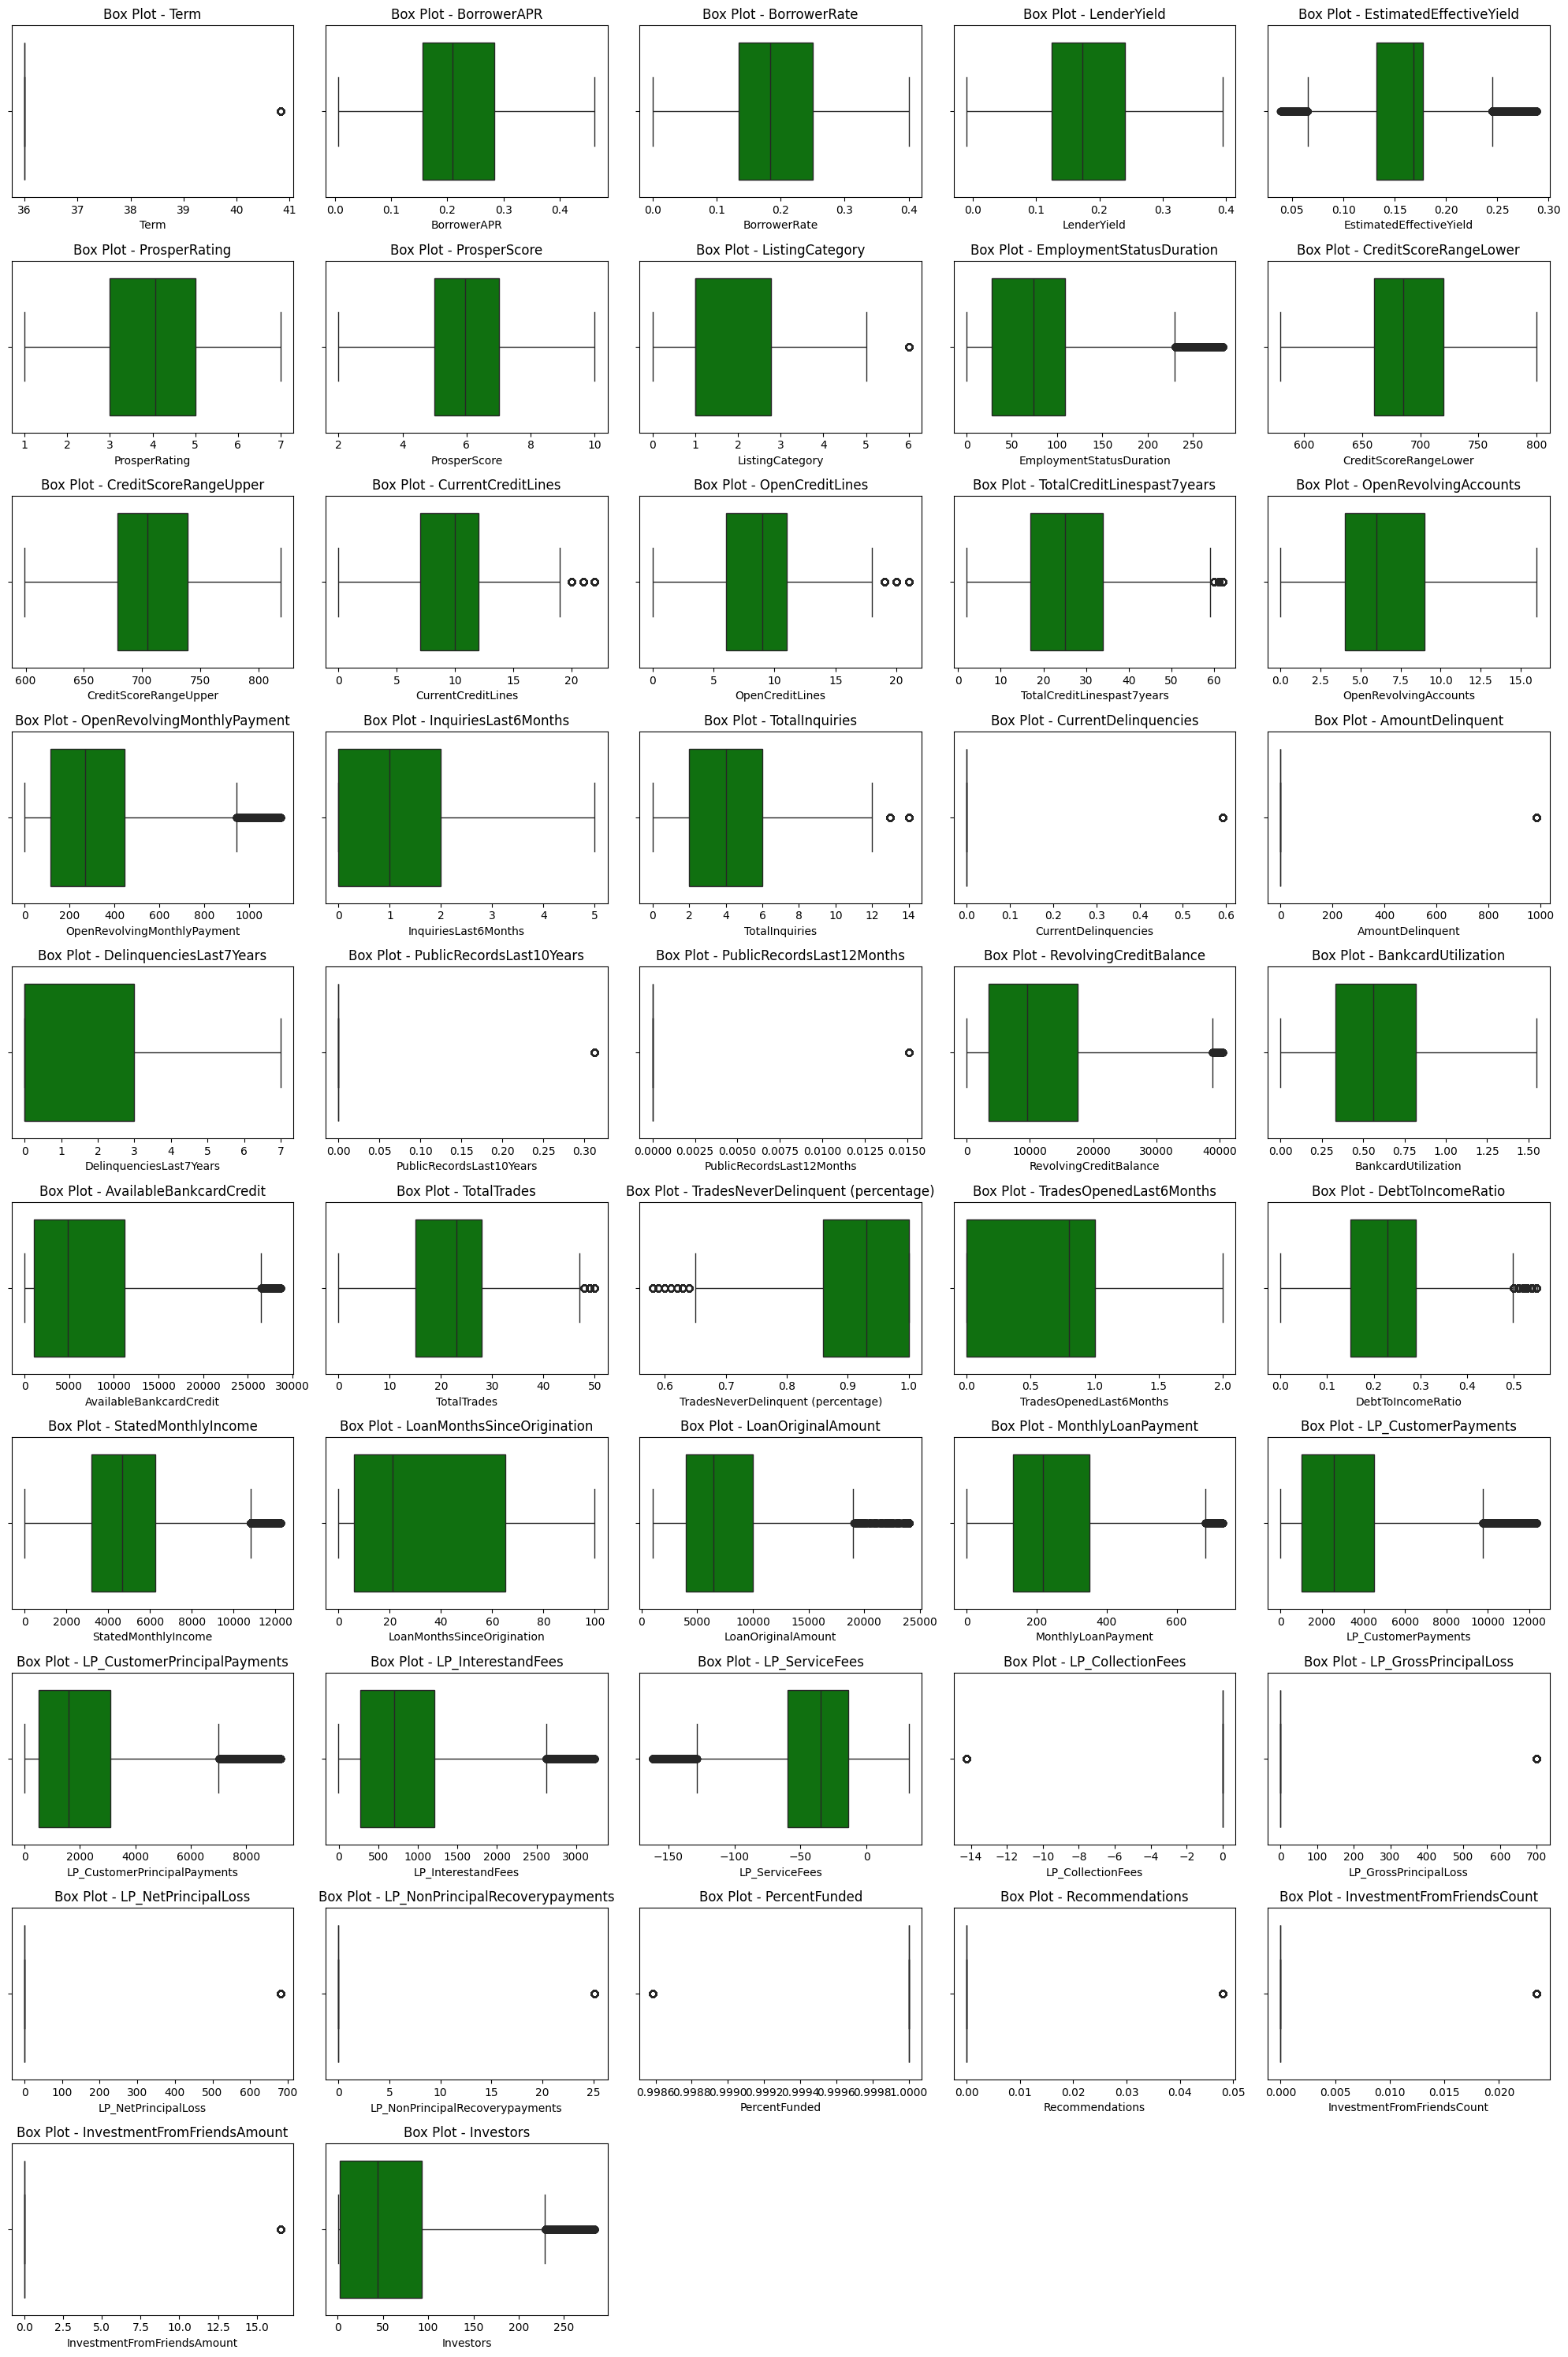

In [ ]:
# Handling outliers using IQR method
for feature in loan_df.columns:
    if loan_df[feature].dtype in ['int64', 'float64']:
        Q1 = loan_df[feature].quantile(0.25)
        Q3 = loan_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_extrem = Q1 - 1.5 * IQR
        upper_extrem = Q3 + 1.5 * IQR
        mean = loan_df[feature].mean()

        # Identify and replace outliers
        loan_df.loc[loan_df[feature] < lower_extrem, feature] = mean
        loan_df.loc[loan_df[feature] > upper_extrem, feature] = mean

# Checking for outliers after handling
plt.figure(figsize=(20, 30))

# Create subplots
for i, column in enumerate(num_cols, 1):
    plt.subplot(10, 5, i)
    sns.boxplot(x=loan_df[column], color='green')
    plt.title(f'Box Plot - {column}')

# Adjust layout
plt.tight_layout()
plt.show()

## Data Encoding

In [ ]:
cate_cols = loan_df.select_dtypes(include=['category', 'object']).columns
cate_cols

Index(['CreditGrade', 'BorrowerState', 'Occupation', 'EmploymentStatus',
       'IncomeRange', 'LoanOriginationQuarter', 'Status'],
      dtype='object')

In [ ]:
credit_grade_mapping = {'NC': 0, 'HR': 1, 'E': 2, 'D': 3, 'C': 4, 'B': 5, 'A': 6, 'AA': 7}

In [ ]:
le=LabelEncoder()
cols=['Status','CreditGrade','BorrowerState','Occupation','EmploymentStatus','IsBorrowerHomeowner','CurrentlyInGroup','IncomeVerifiable',
      'LoanOriginationQuarter','IncomeRange']

loan_df[cols]=loan_df[cols].apply(LabelEncoder().fit_transform)
loan_df.head()

CreditGrade  Term  BorrowerAPR  BorrowerRate  LenderYield  \
0            3  36.0      0.16516        0.1580       0.1380   
1            3  36.0      0.12016        0.0920       0.0820   
2            6  36.0      0.28269        0.2750       0.2400   
3            3  36.0      0.12528        0.0974       0.0874   
4            3  36.0      0.24614        0.2085       0.1985   

   EstimatedEffectiveYield  ProsperRating  ProsperScore  ListingCategory  \
0                 0.168661       4.072243      5.950067         0.000000   
1                 0.079600       6.000000      7.000000         2.000000   
2                 0.168661       4.072243      5.950067         0.000000   
3                 0.084900       6.000000      9.000000         2.774209   
4                 0.183160       3.000000      4.000000         2.000000   

   BorrowerState  Occupation  EmploymentStatus  EmploymentStatusDuration  \
0              5          35                 7                  2.000000   
1              5          41                 0                 44.000000   
2             10          35                 2                 96.071582   
3             10          50                 0                113.000000   
4             23          19                 0                 44.000000   

   IsBorrowerHomeowner  CurrentlyInGroup  CreditScoreRangeLower  \
0                    1                 1             640.000000   
1                    0                 0             680.000000   
2                    0                 1             685.567731   
3                    1                 0             800.000000   
4                    1                 0             680.000000   

   CreditScoreRangeUpper  CurrentCreditLines  OpenCreditLines  \
0             659.000000            5.000000         4.000000   
1             699.000000           14.000000        14.000000   
2             704.567731           10.317192         9.260164   
3             819.000000            5.000000         5.000000   
4             699.000000           19.000000        19.000000   

   TotalCreditLinespast7years  OpenRevolvingAccounts  \
0                        12.0                    1.0   
1                        29.0                   13.0   
2                         3.0                    0.0   
3                        29.0                    7.0   
4                        49.0                    6.0   

   OpenRevolvingMonthlyPayment  InquiriesLast6Months  TotalInquiries  \
0                         24.0                   3.0             3.0   
1                        389.0                   3.0             5.0   
2                          0.0                   0.0             1.0   
3                        115.0                   0.0             1.0   
4                        220.0                   1.0             9.0   

   CurrentDelinquencies  AmountDelinquent  DelinquenciesLast7Years  \
0              0.592052        984.507059                 4.000000   
1              0.000000          0.000000                 0.000000   
2              0.592052        984.507059                 0.000000   
3              0.592052        984.507059                 4.154984   
4              0.000000          0.000000                 0.000000   

   PublicRecordsLast10Years  PublicRecordsLast12Months  \
0                  0.000000                   0.000000   
1                  0.312646                   0.000000   
2                  0.000000                   0.015094   
3                  0.000000                   0.000000   
4                  0.000000                   0.000000   

   RevolvingCreditBalance  BankcardUtilization  AvailableBankcardCredit  \
0                0.000000             0.000000              1500.000000   
1             3989.000000             0.210000             10266.000000   
2            17598.706751             0.561309             11210.225447   
3             1444.000000             0.040000             11210.22544

## Feature Engineering

## Correlation Matrix

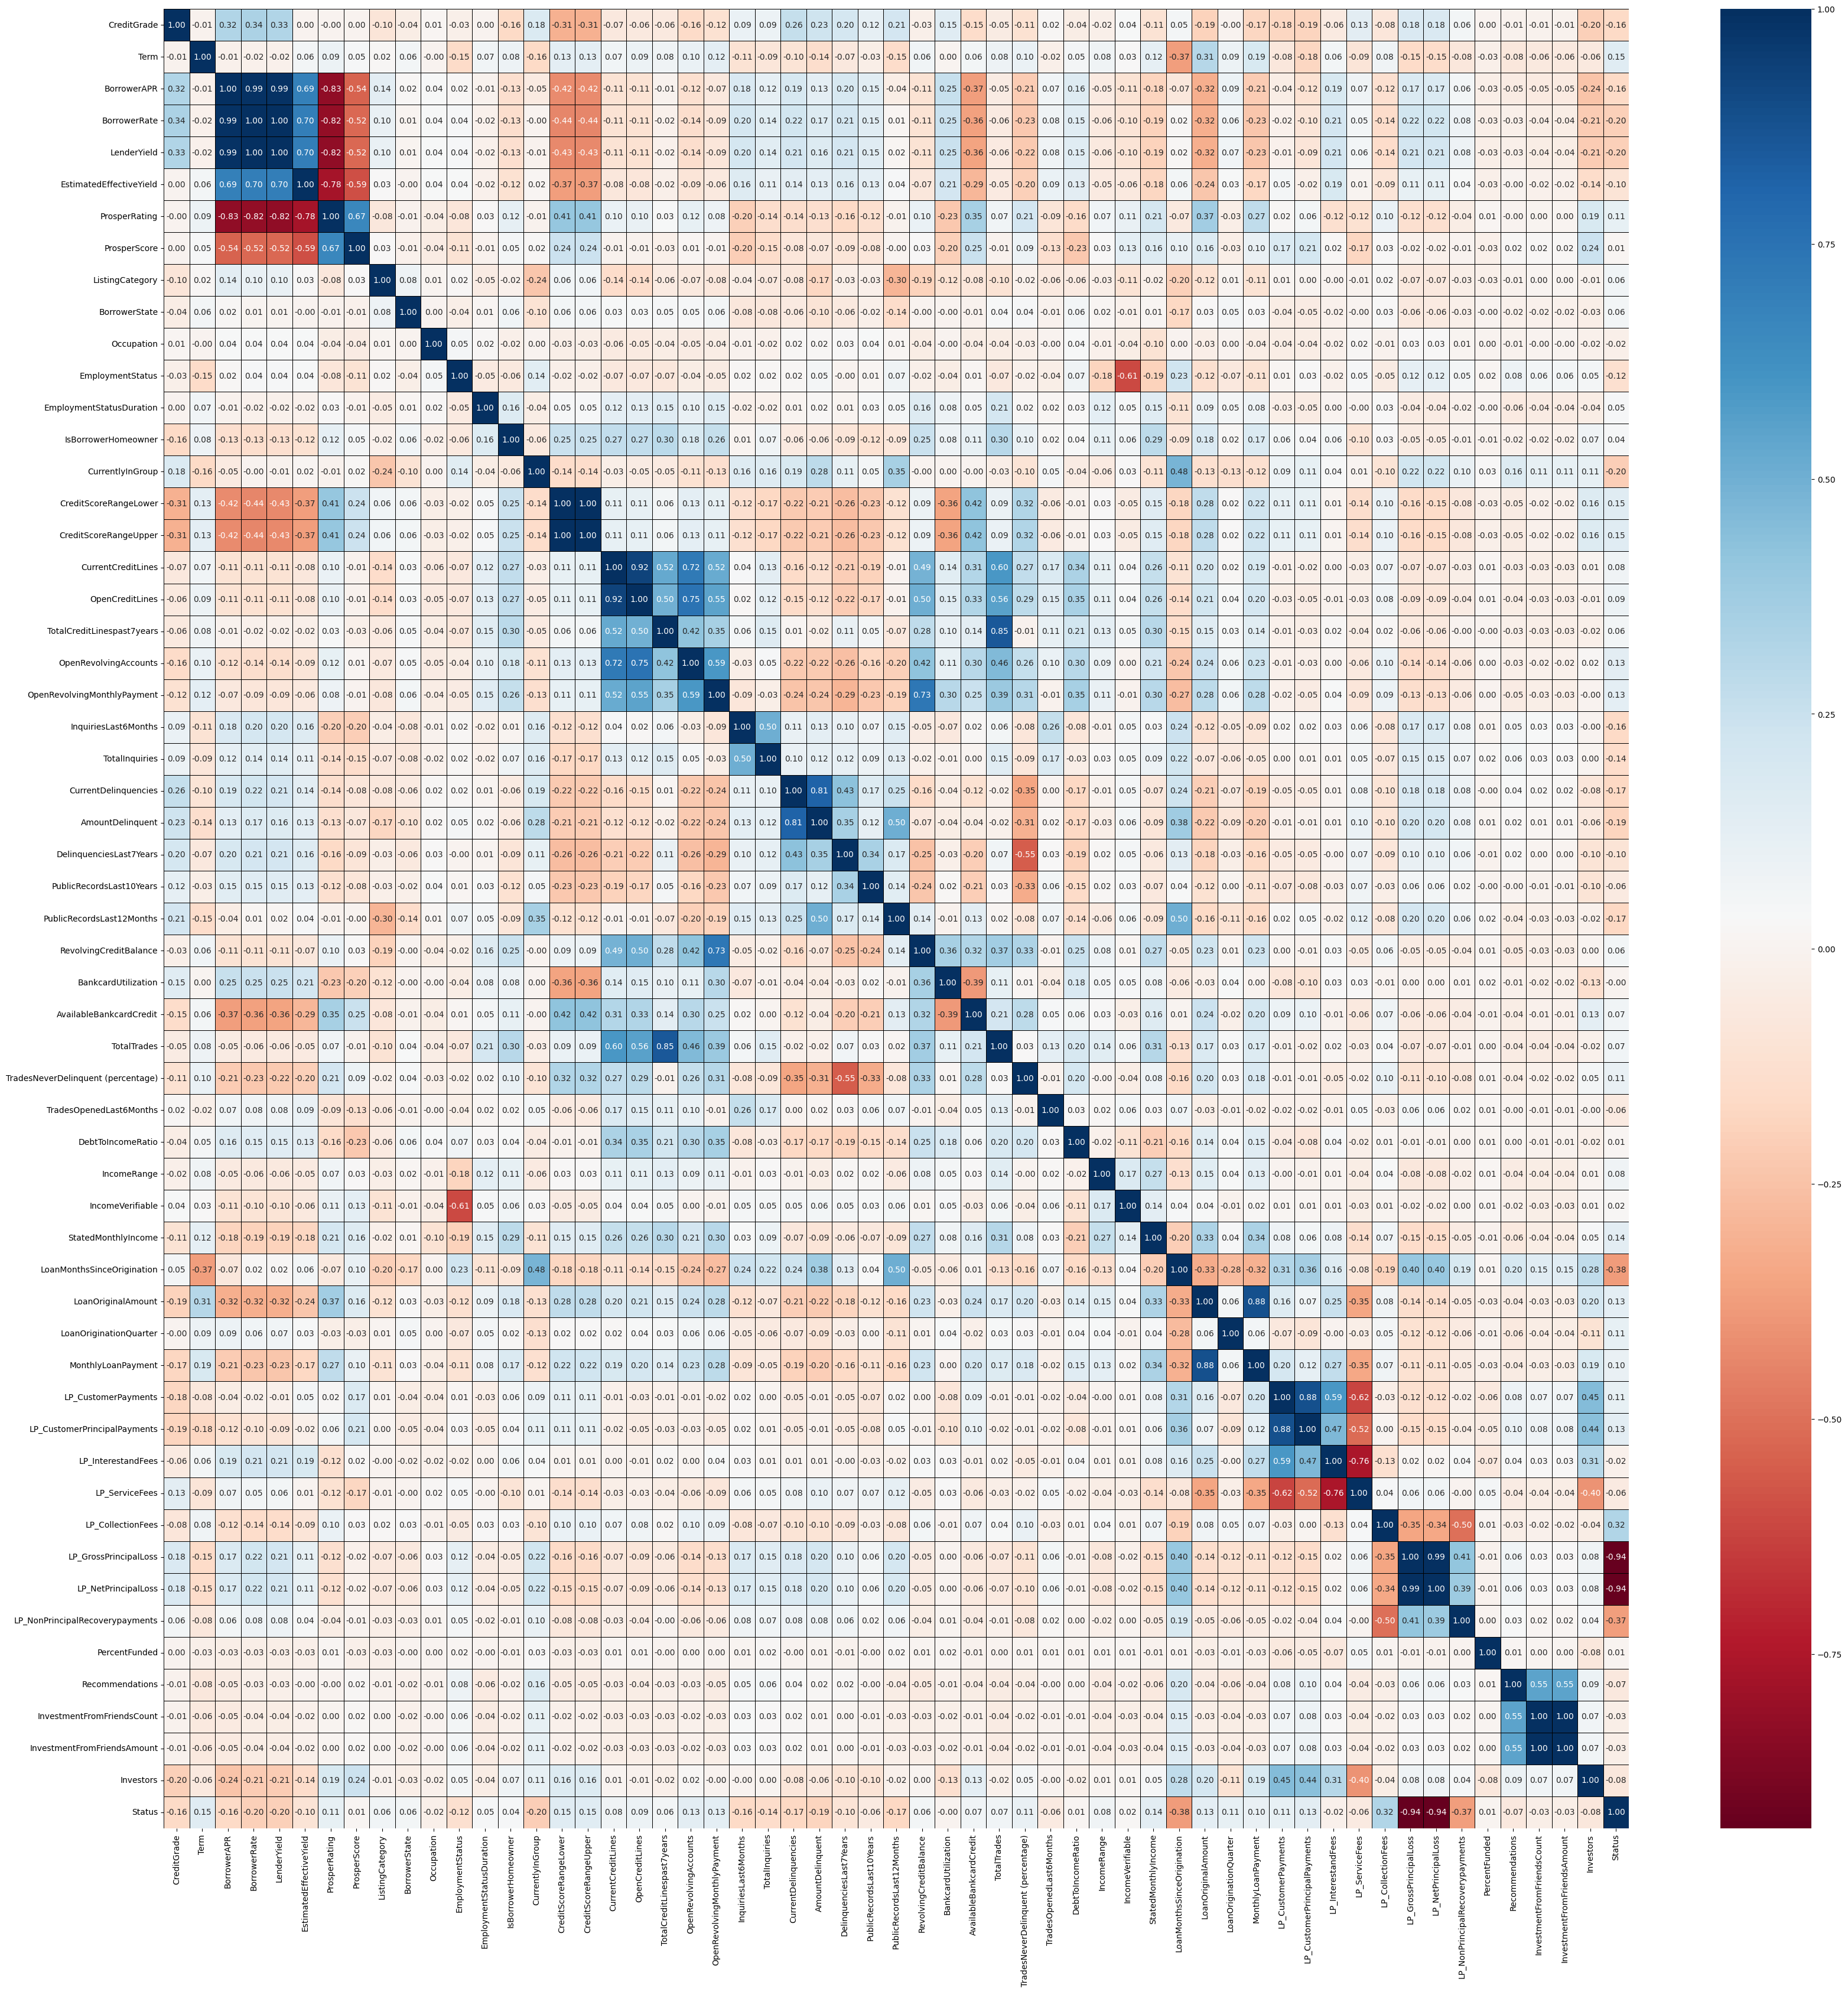

In [ ]:
# Calculate the correlation matrix
correlation_matrix = loan_df.corr()

plt.figure(figsize=(40, 40))
# Create a heatmap with seaborn
sns.heatmap(correlation_matrix, cmap="RdBu", annot=True, fmt=".2f", linewidths=0.5, linecolor="black")

# Show the plot
plt.show()

##### Based on the provided correlation matrix, here are some findings related to the target variables status" and "borrower rate":

* "Status" is negatively correlated with "borrower rate" and "debt to income ratio" meaning that higher borrower rates are associated with a lower likelihood of loan repayment. And the borrowers with lower debt-to-income ratios are more likely to repay their loans.
<br>

* "Status" is positively correlated with "credit score range lower","credit score range upper","income range" and "income verifiable". Indicating that borrowers with higher credit scores are more likely to repay their loans. And implying that borrowers with higher incomes and verified income information are more likely to repay their loans.
<br>

* "Borrower rate" is positively correlated with "borrower APR","lender yield" and debt to income ratio", indicating that higher borrower rates are associated with higher costs for borrowers and lenders.And implying that borrowers with higher debt-to-income ratios are more likely to have higher borrower rates.
<br>

* "Borrower rate" is negatively correlated with "credit score range lower", "credit score range upper","income range" and "income verifiable",  suggesting that borrowers with lower credit scores are more likely to have higher borrower rates. And indicating that borrowers with lower incomes and unverified income information are more likely to have higher borrower rates.
<br>

Overall, these findings suggest that credit score, debt-to-income ratio, and income information are important factors in predicting loan repayment and borrower rates.

In [ ]:
loan_df.head()

CreditGrade  Term  BorrowerAPR  BorrowerRate  LenderYield  \
0            3  36.0      0.16516        0.1580       0.1380   
1            3  36.0      0.12016        0.0920       0.0820   
2            6  36.0      0.28269        0.2750       0.2400   
3            3  36.0      0.12528        0.0974       0.0874   
4            3  36.0      0.24614        0.2085       0.1985   

   EstimatedEffectiveYield  ProsperRating  ProsperScore  ListingCategory  \
0                 0.168661       4.072243      5.950067         0.000000   
1                 0.079600       6.000000      7.000000         2.000000   
2                 0.168661       4.072243      5.950067         0.000000   
3                 0.084900       6.000000      9.000000         2.774209   
4                 0.183160       3.000000      4.000000         2.000000   

   BorrowerState  Occupation  EmploymentStatus  EmploymentStatusDuration  \
0              5          35                 7                  2.000000   
1              5          41                 0                 44.000000   
2             10          35                 2                 96.071582   
3             10          50                 0                113.000000   
4             23          19                 0                 44.000000   

   IsBorrowerHomeowner  CurrentlyInGroup  CreditScoreRangeLower  \
0                    1                 1             640.000000   
1                    0                 0             680.000000   
2                    0                 1             685.567731   
3                    1                 0             800.000000   
4                    1                 0             680.000000   

   CreditScoreRangeUpper  CurrentCreditLines  OpenCreditLines  \
0             659.000000            5.000000         4.000000   
1             699.000000           14.000000        14.000000   
2             704.567731           10.317192         9.260164   
3             819.000000            5.000000         5.000000   
4             699.000000           19.000000        19.000000   

   TotalCreditLinespast7years  OpenRevolvingAccounts  \
0                        12.0                    1.0   
1                        29.0                   13.0   
2                         3.0                    0.0   
3                        29.0                    7.0   
4                        49.0                    6.0   

   OpenRevolvingMonthlyPayment  InquiriesLast6Months  TotalInquiries  \
0                         24.0                   3.0             3.0   
1                        389.0                   3.0             5.0   
2                          0.0                   0.0             1.0   
3                        115.0                   0.0             1.0   
4                        220.0                   1.0             9.0   

   CurrentDelinquencies  AmountDelinquent  DelinquenciesLast7Years  \
0              0.592052        984.507059                 4.000000   
1              0.000000          0.000000                 0.000000   
2              0.592052        984.507059                 0.000000   
3              0.592052        984.507059                 4.154984   
4              0.000000          0.000000                 0.000000   

   PublicRecordsLast10Years  PublicRecordsLast12Months  \
0                  0.000000                   0.000000   
1                  0.312646                   0.000000   
2                  0.000000                   0.015094   
3                  0.000000                   0.000000   
4                  0.000000                   0.000000   

   RevolvingCreditBalance  BankcardUtilization  AvailableBankcardCredit  \
0                0.000000             0.000000              1500.000000   
1             3989.000000             0.210000             10266.000000   
2            17598.706751             0.561309             11210.225447   
3             1444.000000             0.040000             11210.22544

### Principle Component Analysis


Principal Component Analysis (PCA) is a dimensionality reduction technique widely used in various fields, including statistics, machine learning, and signal processing.

In this step, you are using the StandardScaler to standardize your dataset.

In [ ]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(loan_df)

Then create a PCA object and apply it to the standardized data. The fit_transform method computes the principal components of the data.

In [ ]:
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

In [ ]:
# You can check the explained variance ratio to decide on the number of components to keep
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [1.41616751e-01 8.75637601e-02 7.04570001e-02 6.11419366e-02
 4.77761883e-02 4.37172196e-02 3.69691874e-02 3.32258408e-02
 2.83786992e-02 2.62484044e-02 2.45860778e-02 2.15304505e-02
 2.02917167e-02 1.86895209e-02 1.81283497e-02 1.73466944e-02
 1.70644766e-02 1.67276858e-02 1.61707141e-02 1.59910072e-02
 1.49841046e-02 1.46310032e-02 1.43028880e-02 1.39812616e-02
 1.19636625e-02 1.18165782e-02 1.14058232e-02 1.12526321e-02
 1.08073119e-02 1.03430613e-02 9.96259103e-03 9.33630516e-03
 9.18274610e-03 8.45172324e-03 8.18023818e-03 7.58761763e-03
 7.15803547e-03 6.88103139e-03 6.31614712e-03 5.76712276e-03
 4.71938662e-03 4.54269219e-03 3.64193295e-03 3.27399269e-03
 3.06717567e-03 2.31993790e-03 2.24123326e-03 1.99735497e-03
 1.70293071e-03 1.66079721e-03 1.44268449e-03 1.22653430e-03
 1.12108349e-04 1.06852263e-04 1.08205024e-05 4.16747306e-19
 0.00000000e+00]


In these output, the explained variance ratio is a list of values, each corresponding to a principal component. These values represent the proportion of the total variance explained by each component.

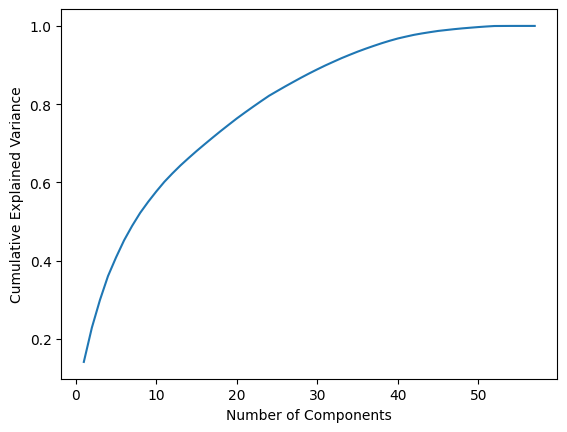

In [ ]:
cumulative_variance = np.cumsum(explained_variance_ratio)
# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

## Feature Selection with Mutual Information


Mutual information measures the dependency between two variables. In this case, it quantifies the relationship between each feature and the target variable (Status). Higher values indicate stronger relationships

In [ ]:
features = loan_df.drop('Status', axis=1)  # Exclude the target variable if applicable
target = loan_df['Status']

# Compute mutual information
mutual_info_values = mutual_info_classif(features, target)

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame(mutual_info_values, index=features.columns, columns=['Mutual Information'])
feature_importance.sort_values(by='Mutual Information', ascending=False, inplace=True)
print(feature_importance)

                                    Mutual Information
LP_GrossPrincipalLoss                         0.340394
LP_NetPrincipalLoss                           0.337490
BorrowerAPR                                   0.095986
LoanMonthsSinceOrigination                    0.091298
LoanOriginationQuarter                        0.090513
EstimatedEffectiveYield                       0.089072
BorrowerRate                                  0.082494
LP_CustomerPrincipalPayments                  0.080200
LenderYield                                   0.080030
ProsperRating                                 0.068161
MonthlyLoanPayment                            0.062209
CreditGrade                                   0.058453
ProsperScore                                  0.054976
LP_CustomerPayments                           0.052505
EmploymentStatus                              0.042517
LP_NonPrincipalRecoverypayments               0.042373
ListingCategory                               0.041401
LP_Collect

**Features according to Mutual Information:**

Features are ranked based on their Mutual Information values, indicating the strength of their relationship with the target variable. features with high Mutual Information values include.
<br>
* LP_GrossPrincipalLoss (0.339993)
* LP_NetPrincipalLoss (0.336823)
* BorrowerAPR (0.094329)
* LoanMonthsSinceOrigination (0.090384)
* EstimatedEffectiveYield (0.089245)
* LP_CustomerPrincipalPayments (0.080646)
* LenderYield (0.079469)
* ProsperRating (0.070498)

### Correlation with BorrowerRate

The correlation coefficients between each feature and the target variable ("BorrowerRate").

In [ ]:
# Assuming X is your feature matrix and y_borrower_rate is the target variable "BorrowerRate"
X = loan_df.drop(["BorrowerRate"], axis=1)  # Features
y_borrower_rate = loan_df["BorrowerRate"]  # Target variable

# Calculate correlation coefficients
correlation_scores = X.corrwith(y_borrower_rate)

# Display correlation coefficients for each feature
correlation_df = pd.DataFrame({"Feature": X.columns, "Correlation_with_BorrowerRate": correlation_scores})
correlation_df = correlation_df.sort_values(by="Correlation_with_BorrowerRate", ascending=False)
print(correlation_df)

                                                               Feature  \
LenderYield                                                LenderYield   
BorrowerAPR                                                BorrowerAPR   
EstimatedEffectiveYield                        EstimatedEffectiveYield   
CreditGrade                                                CreditGrade   
BankcardUtilization                                BankcardUtilization   
CurrentDelinquencies                              CurrentDelinquencies   
LP_GrossPrincipalLoss                            LP_GrossPrincipalLoss   
LP_NetPrincipalLoss                                LP_NetPrincipalLoss   
LP_InterestandFees                                  LP_InterestandFees   
DelinquenciesLast7Years                        DelinquenciesLast7Years   
InquiriesLast6Months                              InquiriesLast6Months   
AmountDelinquent                                      AmountDelinquent   
PublicRecordsLast10Years              

Features are ranked based on their correlation with the target variable, with positive values indicating a positive correlation and negative values indicating a negative correlation.
Features such as:
* LenderYield
* BorrowerAPR
* EstimatedEffectiveYield
* CreditGrade<br>
shows a strong positive correlation with the target variable.

Key Findings:

* Features like "LP_GrossPrincipalLoss," "LP_NetPrincipalLoss," and "BorrowerAPR" are consistently identified as important by both methods.
* The correlation coefficients indicate the direction and strength of the linear relationship between each feature and the target variable.
* Some features have high Mutual Information but lower correlation and vice versa, highlighting the complementary nature of the two methods.

### Split The Data
we will divide our dataset into two variables `X` as the features we defined earlier and `y` as the `Status` the target value we want to predict.

In [ ]:
# Separate features (X) and target variable (y)
X = loan_df.drop('Status', axis=1)
y = loan_df['Status']

In [ ]:
# Load your dataset and split it into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(113937, 56) (91149, 56) (22788, 56)


### Feature Selection

In [ ]:
#Now we Will select the  top 5 important features
sel_five_cols = SelectKBest(mutual_info_classif, k=10)
sel_five_cols.fit(X_train, y_train)
selected_features = X_train.columns[sel_five_cols.get_support()]
selected_features

Index(['BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield',
       'ProsperRating', 'LoanMonthsSinceOrigination', 'LoanOriginationQuarter',
       'LP_CustomerPrincipalPayments', 'LP_GrossPrincipalLoss',
       'LP_NetPrincipalLoss'],
      dtype='object')

In [ ]:
Features_selected = ['BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield',
       'ProsperRating', 'LoanMonthsSinceOrigination', 'LoanOriginationQuarter',
       'LP_CustomerPrincipalPayments', 'LP_GrossPrincipalLoss',
       'LP_NetPrincipalLoss','Status']

In [ ]:
Features_dropped = ['EmploymentStatus','Investors','InvestmentFromFriendsAmount','EmploymentStatus','Investors',
                    'InvestmentFromFriendsAmount','InvestmentFromFriendsCount','Term','ListingCategory','IsBorrowerHomeowner',
                    'CurrentlyInGroup','CurrentCreditLines','OpenCreditLines', 'TotalCreditLinespast7years',
                    'OpenRevolvingAccounts','OpenRevolvingMonthlyPayment','InquiriesLast6Months','TotalInquiries',
                    'CurrentDelinquencies','AmountDelinquent','DelinquenciesLast7Years','PublicRecordsLast12Months',
                    'PublicRecordsLast10Years','RevolvingCreditBalance', 'LP_CustomerPayments',
                    'LP_InterestandFees','Recommendations','PercentFunded','EmploymentStatusDuration','TradesNeverDelinquent (percentage)',
                    'TradesOpenedLast6Months','LP_CollectionFees', 'LP_NonPrincipalRecoverypayments','DebtToIncomeRatio',
                    'LP_ServiceFees','TotalTrades','ProsperScore','BorrowerState', 'Occupation','BankcardUtilization','AvailableBankcardCredit',
                   'IncomeVerifiable']

loan_df.drop(Features_dropped,axis=1,inplace=True)
loan_df.shape

(113937, 18)

In [ ]:
loan_df.head()

CreditGrade  BorrowerAPR  BorrowerRate  LenderYield  \
0            3      0.16516        0.1580       0.1380   
1            3      0.12016        0.0920       0.0820   
2            6      0.28269        0.2750       0.2400   
3            3      0.12528        0.0974       0.0874   
4            3      0.24614        0.2085       0.1985   

   EstimatedEffectiveYield  ProsperRating  CreditScoreRangeLower  \
0                 0.168661       4.072243             640.000000   
1                 0.079600       6.000000             680.000000   
2                 0.168661       4.072243             685.567731   
3                 0.084900       6.000000             800.000000   
4                 0.183160       3.000000             680.000000   

   CreditScoreRangeUpper  IncomeRange  StatedMonthlyIncome  \
0             659.000000            3          3083.333333   
1             699.000000            4          6125.000000   
2             704.567731            3          2083.333333   
3             819.000000            3          2875.000000   
4             699.000000            2          9583.333333   

   LoanMonthsSinceOrigination  LoanOriginalAmount  LoanOriginationQuarter  \
0                        78.0              9425.0                      17   
1                         0.0             10000.0                       7   
2                        86.0              3001.0                       1   
3                        16.0             10000.0                      31   
4                         6.0             15000.0                      23   

   MonthlyLoanPayment  LP_CustomerPrincipalPayments  LP_GrossPrincipalLoss  \
0              330.43                   3105.536588                    0.0   
1              318.93                      0.000000                    0.0   
2              123.32                   3001.000000                    0.0   
3              321.45                   4091.090000                    0.0   
4              563.97                   1563.220000                    0.0   

   LP_NetPrincipalLoss  Status  
0                  0.0       1  
1                  0.0       1  
2                  0.0       1  
3                  0.0       1  
4                  0.0       1

# Machine learning models

This is the classification problem so we used two models:<br>
**1)** Logistic Regression<br>
**2)** Naive Bayes Classification

## Logistic Regression

Logistic Regression is a powerful and commonly used statistical method for modeling the probability of binary outcomes. Its simplicity, interpretability, and effectiveness make it a popular choice in various domains for solving classification problems.

In [ ]:
# Hyperparameter tuning for Logistic Regression
logreg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l2'],  # Regularization type compatible with 'liblinear' solver
    'solver': ['liblinear'],  # Solver compatible with 'l2' penalty
    'max_iter': [100, 200, 300]  # Increase max_iter to allow for more iterations
}

In [ ]:
logreg = LogisticRegression()
logreg_grid = GridSearchCV(logreg, logreg_params, cv=5)
logreg_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300], 'penalty': ['l2'],
                         'solver': ['liblinear']})

In [ ]:
# Print the best hyperparameters for Logistic Regression
print("Best Hyperparameters for Logistic Regression: ", logreg_grid.best_params_)

Best Hyperparameters for Logistic Regression:  {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
# Use the best model for prediction
logreg_best = logreg_grid.best_estimator_
logreg_predictions = logreg_best.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
print("Logistic Regression Accuracy: ", logreg_accuracy)

Logistic Regression Accuracy:  0.9840705634544498


In [ ]:
# Use the best model for prediction on the training set
logreg_train_predictions = logreg_best.predict(X_train)
logreg_train_accuracy = accuracy_score(y_train, logreg_train_predictions)
print("Logistic Regression Training Accuracy: ", logreg_train_accuracy)

Logistic Regression Training Accuracy:  0.9841029523088569


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification report and confusion matrix for the test set
print("Classification Report for Logistic Regression on Test Set:")
print(classification_report(y_test, logreg_predictions))
print("Confusion Matrix for Logistic Regression on Test Set:")
print(confusion_matrix(y_test, logreg_predictions))

# Classification report and confusion matrix for the training set
print("Classification Report for Logistic Regression on Training Set:")
print(classification_report(y_train, logreg_train_predictions))
print("Confusion Matrix for Logistic Regression on Training Set:")
print(confusion_matrix(y_train, logreg_train_predictions))


Classification Report for Logistic Regression on Test Set:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      3039
           1       1.00      0.98      0.99     19749

    accuracy                           0.98     22788
   macro avg       0.95      0.99      0.97     22788
weighted avg       0.99      0.98      0.98     22788

Confusion Matrix for Logistic Regression on Test Set:
[[ 3025    14]
 [  349 19400]]
Classification Report for Logistic Regression on Training Set:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94     12024
           1       1.00      0.98      0.99     79125

    accuracy                           0.98     91149
   macro avg       0.95      0.99      0.97     91149
weighted avg       0.99      0.98      0.98     91149

Confusion Matrix for Logistic Regression on Training Set:
[[11975    49]
 [ 1400 77725]]


# Naive Bayes

Naive Bayes is a probabilistic machine learning algorithm that is commonly used for classification tasks. It is based on Bayes' theorem, which describes the probability of an event based on prior knowledge of conditions that might be related to the event.

In [ ]:
# Hyperparameter tuning for Naive Bayes
nb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Smoothing parameter for GaussianNB
}

naive_bayes = GaussianNB()
nb_grid = GridSearchCV(naive_bayes, nb_params, cv=5)
nb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]})

In [ ]:
# Print the best hyperparameters for Naive Bayes
print("Best Hyperparameters for Naive Bayes: ", nb_grid.best_params_)

Best Hyperparameters for Naive Bayes:  {'var_smoothing': 1e-07}


In [ ]:
# Use the best model for prediction
nb_best = nb_grid.best_estimator_
nb_predictions = nb_best.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy: ", nb_accuracy)

Naive Bayes Accuracy:  0.9842460944356679


In [ ]:
# Classification report and confusion matrix for the test set
print("Classification Report for Naive Bayes on Test Set:")
print(classification_report(y_test, nb_predictions))
print("Confusion Matrix for Naive Bayes on Test Set:")
print(confusion_matrix(y_test, nb_predictions))

# Optionally, you can evaluate on the training set as well
nb_train_predictions = nb_best.predict(X_train)
print("Classification Report for Naive Bayes on Training Set:")
print(classification_report(y_train, nb_train_predictions))
print("Confusion Matrix for Naive Bayes on Training Set:")
print(confusion_matrix(y_train, nb_train_predictions))

Classification Report for Naive Bayes on Test Set:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      3039
           1       1.00      0.98      0.99     19749

    accuracy                           0.98     22788
   macro avg       0.95      0.99      0.97     22788
weighted avg       0.99      0.98      0.98     22788

Confusion Matrix for Naive Bayes on Test Set:
[[ 3024    15]
 [  344 19405]]
Classification Report for Naive Bayes on Training Set:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     12024
           1       1.00      0.98      0.99     79125

    accuracy                           0.98     91149
   macro avg       0.95      0.99      0.97     91149
weighted avg       0.99      0.98      0.98     91149

Confusion Matrix for Naive Bayes on Training Set:
[[11959    65]
 [ 1388 77737]]


## Cross Validation

In [ ]:
# Logistic Regression cross-validated performance
logreg_cv_scores = cross_val_score(logreg_best, X_train, y_train, cv=5)
print("Cross-validated Accuracy for Logistic Regression: ", np.mean(logreg_cv_scores))

# Naive Bayes cross-validated performance
nb_cv_scores = cross_val_score(nb_best, X_train, y_train, cv=5)
print("Cross-validated Accuracy for Naive Bayes: ", np.mean(nb_cv_scores))


Cross-validated Accuracy for Logistic Regression:  0.98405907750025
Cross-validated Accuracy for Naive Bayes:  0.9840590744910539


### General Observations:
Both models demonstrate high accuracy on the test set, indicating good generalization.The confusion matrices show that both models perform well in correctly classifying both classes (0 and 1). The classification reports provide a detailed breakdown of precision, recall, and F1-score for each class. Evaluation on the training set shows similar high accuracy, suggesting that the models are not overfitting. The hyperparameter tuning process involved using grid search with cross-validation (cv=5) to find the best combination of parameters.


## Decision Tree Classifier

A decision tree is a flowchart-like structure that splits data into subsets based on certain features. Each split, or decision node, creates a binary branch: one leading to an outcome or class (positive or negative, for example), and the other leading to another decision node. Decision trees are widely used in machine learning and data mining for both classification and regression tasks.

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_decision_tree = grid_search.best_estimator_
best_decision_tree.fit(X_train, y_train)
# Make predictions on the test set
y_pred_dt_tuned = best_decision_tree.predict(X_test)

# Evaluate the tuned Decision Tree model
accuracy_dt_tuned = accuracy_score(y_test, y_pred_dt_tuned)
conf_matrix_dt_tuned = confusion_matrix(y_test, y_pred_dt_tuned)
classification_report_str_dt_tuned = classification_report(y_test, y_pred_dt_tuned)

print("Tuned Decision Tree Model:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_dt_tuned}")
print(f"Confusion Matrix:\n{conf_matrix_dt_tuned}")
print(f"Classification Report:\n{classification_report_str_dt_tuned}")

Tuned Decision Tree Model:
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
Accuracy: 0.9842022116903634
Confusion Matrix:
[[ 2997    42]
 [  318 19431]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3039
           1       1.00      0.98      0.99     19749

    accuracy                           0.98     22788
   macro avg       0.95      0.99      0.97     22788
weighted avg       0.99      0.98      0.98     22788



## Support Vector Machine

Support Vector Machines (SVM) is a supervised machine learning algorithm that can be used for classification or regression tasks. SVM is particularly effective in high-dimensional spaces and is widely used in various applications, including image classification, text classification, and bioinformatics.

In [ ]:
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions on the test set for SVM
y_pred_svm = svm_model.predict(X_test)

# Evaluate the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
classification_report_str_svm = classification_report(y_test, y_pred_svm)

print("SVM Model:")
print(f"Accuracy: {accuracy_svm}")
print(f"Confusion Matrix:\n{conf_matrix_svm}")
print(f"Classification Report:\n{classification_report_str_svm}")

SVM Model:
Accuracy: 0.9842022116903634
Confusion Matrix:
[[ 3025    14]
 [  346 19403]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      3039
           1       1.00      0.98      0.99     19749

    accuracy                           0.98     22788
   macro avg       0.95      0.99      0.97     22788
weighted avg       0.99      0.98      0.98     22788



In [ ]:
# prompt: save the model pickle files

import pickle

# Assuming 'logreg_best', 'nb_best', 'best_decision_tree', and 'svm_model' are your trained models
# Replace these with your actual model variable names

# Save the models to pickle files in your Google Drive
with open('/content/drive/My Drive/logreg_model.pkl', 'wb') as f:
    pickle.dump(logreg_best, f)

with open('/content/drive/My Drive/nb_model.pkl', 'wb') as f:
    pickle.dump(nb_best, f)

with open('/content/drive/My Drive/decision_tree_model.pkl', 'wb') as f:
    pickle.dump(best_decision_tree, f)

with open('/content/drive/My Drive/svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
